# Action/observational trigger plotting
<!-- markdownlint-disable MD013 -->
Picking out combinations of action (forecast, limited to 3 days) and observational triggers. All trigger combination options have the same overall return period (3.7 years, which is 7 triggering years in the period 2000-2024).

We varied, each for the forecast and the observational:

- wind speed threshold (while storm is in, or is forecast to be in, the ZMA)
- rainfall aggregation (`mean`, or quantiles 50, 80, 90, 95)
- rainfall threshold (two-day sum per pixel during the period that the storm is in, or is forecast to be in, the ZMA, ±1 day)

And we are looking to optimize for (maximizing):

- Sum of `Total Affected` from EM-DAT for the triggered storms
- Sum of `Amount in US$` from CERF for the triggered storms

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import ocha_stratus as stratus
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from src.datasources.ibtracs import knots2cat
from src.constants import *

## Load and process data

In [3]:
blob_name = (
    f"{PROJECT_PREFIX}/processed/fcast_obsv_combined_trigger_metrics.parquet"
)
df_metrics = stratus.load_parquet_from_blob(blob_name)

In [4]:
blob_name = f"{PROJECT_PREFIX}/processed/fcast_obsv_combined_stats.parquet"
df_stats = stratus.load_parquet_from_blob(blob_name)

### Determine theoretical maximum values

In [5]:
# note that we have to pick a differet number of triggered years for CERF since it only started in 2006
cerf_target_years = int((2024 - 2006 + 1 + 1) / 3.7)

In [6]:
# we see that there were 6 CERF years, but we can only hope to target up to 5, because otherwise the RP is too low
df_stats[df_stats["cerf"]].groupby("year")[
    "Amount in US$"
].sum().reset_index().sort_values("Amount in US$", ascending=False)

,year,Amount in US$
5,2024,9499457
3,2017,7999469
4,2022,7827734
0,2008,7367516
1,2012,5522753
2,2016,5352736


In [7]:
max_cerf_amount = (
    df_stats[df_stats["cerf"]]
    .groupby("year")["Amount in US$"]
    .sum()
    .reset_index()
    .sort_values("Amount in US$", ascending=False)
    .iloc[:cerf_target_years]
    .sum()["Amount in US$"]
)

In [8]:
target_years = 7

In [9]:
max_total_affected = (
    df_stats.groupby("year")["Total Affected"]
    .sum()
    .reset_index()
    .sort_values("Total Affected", ascending=False)
    .iloc[:target_years]
    .sum()["Total Affected"]
)

In [10]:
max_total_affected

np.int64(29450226)

### Add metrics and filter redundant values

In [11]:
df_metrics["n_years_diff"] = (
    df_metrics["n_years_fcast"] - df_metrics["n_years_obsv"]
)
df_metrics["n_years_diff_abs"] = df_metrics["n_years_diff"].abs()
df_metrics["n_years_total"] = (
    df_metrics["n_years_fcast"] + df_metrics["n_years_obsv"]
)

In [12]:
def drop_redundant_thresholds(df, min_cols, id_cols, drop_high=True):
    for min_col in min_cols:
        unique_cols = [x for x in min_cols if x != min_col] + id_cols
        df = df.sort_values(min_col, ascending=drop_high).drop_duplicates(
            subset=unique_cols
        )
    return df

In [13]:
thresh_cols = [
    "fcast_wind",
    "fcast_rain_thresh",
    "obsv_wind",
    "obsv_rain_thresh",
]
rain_agg_cols = ["fcast_rain_col", "obsv_rain_col"]
impact_cols = [
    "Total Affected",
    "Total Deaths",
    "Total Damage, Adjusted ('000 US$)",
    "Amount in US$",
]

In [14]:
df_metrics_lowest = drop_redundant_thresholds(
    df_metrics, thresh_cols, impact_cols + rain_agg_cols
)

In [15]:
df_metrics_lowest

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
332720,24745221.0,41.0,8135595.0,23194719.0,4.0,80.0,q50,41.205720,125.0,q50_obsv,2.44,7,4,3,3,11
198088,16341819.0,52.0,13714030.0,26242474.0,5.0,35.0,q95,141.738710,125.0,q50_obsv,2.44,7,4,3,3,11
22746,24843276.0,41.0,11268506.0,28547455.0,5.0,120.0,q80,70.166730,130.0,q50_obsv,2.44,7,4,3,3,11
82763,21735221.0,38.0,11280927.0,20719721.0,4.0,110.0,q80,78.203220,115.0,q50_obsv,2.44,7,6,1,1,13
314406,21495776.0,38.0,8110595.0,15366985.0,3.0,75.0,q50,42.807594,130.0,q50_obsv,2.44,7,4,3,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25202,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,mean,21.936502,30.0,q80_obsv,NaN,7,0,7,7,7
25203,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,mean,21.936502,30.0,q95_obsv,NaN,7,0,7,7,7
100940,16292374.0,52.0,13714030.0,26242474.0,5.0,90.0,q95,140.547760,30.0,mean_obsv,NaN,7,0,7,7,7
100943,16292374.0,52.0,13714030.0,26242474.0,5.0,90.0,q95,140.547760,30.0,q80_obsv,NaN,7,0,7,7,7


## Plotting functions

In [16]:
def plot_thresh_scatter(
    x="Total Affected",
    y="Amount in US$",
    color="n_years_diff_abs",
    zorder_rev=True,
    fcast_pref_only=False,
    same_wind=False,
    same_rain_col=False,
    zero_intercept=False,
    df=None,  # override default dataframe
):
    fig, ax = plt.subplots(figsize=(7, 7))

    if df is None:
        df_plot = df_metrics_lowest.copy()
    else:
        df_plot = df.copy()

    if same_wind:
        df_plot = df_plot[df_plot["fcast_wind"] == df_plot["obsv_wind"]]
    if same_rain_col:
        df_plot = df_plot[
            df_plot["fcast_rain_col"]
            == df_plot["obsv_rain_col"].str.removesuffix("_obsv")
        ]

    if fcast_pref_only:
        df_plot = df_plot[df_plot["n_years_diff"] >= 0]

    for n_years_diff_abs, group in df_plot.groupby(color):
        group.plot(
            x=x,
            y=y,
            marker=".",
            linewidth=0,
            alpha=1,
            label=n_years_diff_abs,
            ax=ax,
            zorder=-n_years_diff_abs if zorder_rev else n_years_diff_abs,
        )

    ax.axhline(max_cerf_amount, linestyle="--", color="dodgerblue")
    ax.axvline(max_total_affected, linestyle="--", color="dodgerblue")

    if zero_intercept:
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)

    ax.legend(title=color)
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

    return fig, ax

In [17]:
max_wind = df_stats[["wind", "wind_obsv"]].max().max()

In [18]:
def get_triggered_storms(index):
    trig = df_metrics_lowest.loc[index]

    df_stats["fcast_trig"] = (df_stats["wind"] >= trig["fcast_wind"]) & (
        df_stats[trig["fcast_rain_col"]] >= trig["fcast_rain_thresh"]
    )

    df_stats["obsv_trig"] = (df_stats["wind_obsv"] >= trig["obsv_wind"]) & (
        df_stats[trig["obsv_rain_col"]] >= trig["obsv_rain_thresh"]
    )

    return df_stats

In [19]:
def plot_selected_threshs(index, impact_col="Total Affected"):
    trig_color = "gold"
    cerf_color = "crimson"

    fig, axs = plt.subplots(1, 2, figsize=(14, 7), dpi=200)

    trig = df_metrics_lowest.loc[index]
    # print(trig)

    df_stats = get_triggered_storms(index)

    figs = []
    for stage, ax in zip(["fcast", "obsv"], axs):
        other_stage = "fcast" if stage == "obsv" else "obsv"
        wind_col = "wind" if stage == "fcast" else "wind_obsv"
        wind_thresh = trig[f"{stage}_wind"]
        rain_col = trig[f"{stage}_rain_col"]
        rain_thresh = trig[f"{stage}_rain_thresh"]

        ymax = df_stats[rain_col].max() * 1.1
        xmax = max_wind * 1.1

        # fig, ax = plt.subplots(dpi=200, figsize=(7, 7))

        bubble_sizes = df_stats[impact_col].fillna(0)
        bubble_sizes_scaled = bubble_sizes / bubble_sizes.max() * 5000

        ax.scatter(
            df_stats[wind_col],
            df_stats[rain_col],
            s=bubble_sizes_scaled,
            c=df_stats["cerf"].apply(lambda x: cerf_color if x else "grey"),
            alpha=0.3,
            edgecolor="none",
            zorder=1,
        )

        for _, row in df_stats.iterrows():
            triggered = row[f"{stage}_trig"]
            other_triggered = row[f"{other_stage}_trig"]
            ax.annotate(
                row["name"].capitalize() + "\n" + str(row["year"]),
                (row[wind_col], row[rain_col]),
                ha="center",
                va="center",
                fontsize=6,
                color=cerf_color if row["cerf"] == True else "k",
                zorder=10 if row["cerf"] else 9,
                alpha=0.8,
                fontstyle="italic" if other_triggered else "normal",
                fontweight="bold" if triggered else "normal",
            )

        ax.axvline(
            wind_thresh,
            color=trig_color,
            linewidth=0.5,
            zorder=0,
        )
        ax.axhline(
            rain_thresh,
            color=trig_color,
            linewidth=0.5,
            zorder=0,
        )
        ax.add_patch(
            mpatches.Rectangle(
                (wind_thresh, rain_thresh),  # bottom left
                xmax - wind_thresh,  # width
                ymax - rain_thresh,  # height
                facecolor=trig_color,
                alpha=0.1,
                zorder=0,
            )
        )

        for cat_value, cat_name in CAT_LIMITS:
            ax.annotate(
                cat_name + " -",
                (cat_value, 0),
                fontstyle="italic",
                color="grey",
                rotation=90,
                va="top",
                ha="center",
                fontsize=8,
            )

        ax.annotate(
            f" {wind_thresh:.0f} ",
            (wind_thresh, 0),
            color=trig_color,
            rotation=90,
            fontsize=10,
            va="top",
            ha="center",
            fontweight="bold",
        )

        ax.annotate(
            f" {rain_thresh:.1f} ",
            (0, rain_thresh),
            color=trig_color,
            fontsize=10,
            va="center",
            ha="right",
            fontweight="bold",
        )

        if rain_col == "mean":
            rain_agg_str = "mean"
        else:
            q = rain_col.removeprefix("q").removesuffix("_obsv")
            if q == "50":
                rain_agg_str = "median"
            else:
                rain_agg_str = f"{q}th quantile"
        ax.set_ylabel(
            f"Two-day rainfall, {rain_agg_str} over whole country (mm)"
        )
        ax.set_xlabel("\nMax. wind speed while in ZMA (knots)")

        ax.set_xlim(left=0, right=xmax)
        ax.set_ylim(bottom=0, top=ymax)

        ax.set_title(
            "Action (forecast)" if stage == "fcast" else "Observational"
        )

        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)

        # figs.append((fig, ax))
    return fig, axs

In [20]:
def set_cerf_str(row):
    if row["cerf"]:
        return "Yes"
    else:
        if row["year"] >= 2006:
            return "No"
        else:
            return "pre-"


def color_df(val):
    if val == "Yes":
        return "background-color: crimson"
    elif val == "No":
        return "background-color: dodgerblue"
    elif val == "Trig.":
        return "background-color: darkorange"
    else:
        return ""


def disp_selected_threshs(index, impact_col="Total Affected"):
    trig_color = "gold"
    cerf_color = "crimson"

    df_disp = get_triggered_storms(index).copy()

    df_disp["CERF"] = df_disp.apply(set_cerf_str, axis=1)

    df_disp["Storm"] = (
        df_disp["name"].str.capitalize() + " " + df_disp["year"].astype(str)
    )
    df_disp["Action"] = df_disp["fcast_trig"].apply(
        lambda x: "Trig." if x else "No trig."
    )
    df_disp["Obsv."] = df_disp["obsv_trig"].apply(
        lambda x: "Trig." if x else "No trig."
    )

    cols = ["Action", "Obsv.", "CERF", impact_col]
    display(
        df_disp.set_index("Storm")[cols]
        .sort_values(impact_col, ascending=False)
        .style.bar(
            subset=impact_col,
            color="mediumpurple",
            # vmax=500000,
            props="width: 150px;",
        )
        .map(color_df)
        .set_table_styles(
            {
                impact_col: [
                    {"selector": "th", "props": [("text-align", "left")]},
                    {"selector": "td", "props": [("text-align", "left")]},
                ]
            }
        )
        .format({"Total Affected": "{:,}"})
    )

## Plot possible combinations

### Balanced

The cluster (option 1 in slides) where the same number of years are triggered with forecast and observational.

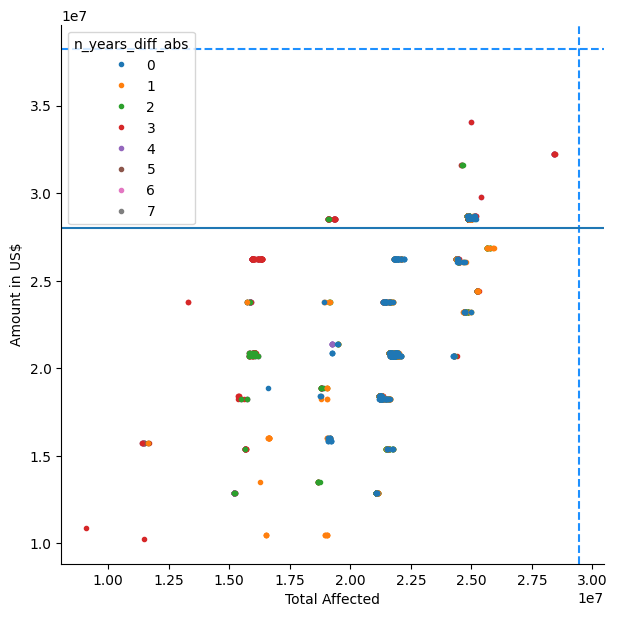

In [25]:
fig, ax = plot_thresh_scatter(
    "Total Affected", "Amount in US$", "n_years_diff_abs"
)
ax.axhline(2.8e7)

In [26]:
df_metrics_balanced = df_metrics_lowest[
    df_metrics_lowest["n_years_diff_abs"] == 0
]

In [27]:
df_metrics_balanced_high = df_metrics_balanced[
    df_metrics_balanced["Amount in US$"] >= 2.8e7
]

In [28]:
df_metrics_balanced_high

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
71389,24843276.0,41.0,11268506.0,28547455.0,5.0,110.0,q95,143.712340,105.0,q50_obsv,45.957497,5,5,0,0,10
119458,25087281.0,45.0,12817901.0,28547455.0,5.0,100.0,q95,143.712340,105.0,q50_obsv,45.957497,5,5,0,0,10
119486,25187281.0,49.0,13866888.0,28547455.0,5.0,100.0,q95,143.409800,105.0,q50_obsv,45.957497,5,5,0,0,10
71417,24943276.0,45.0,12317493.0,28547455.0,5.0,110.0,q95,143.409800,105.0,q50_obsv,45.957497,5,5,0,0,10
60832,24865326.0,52.0,8098174.0,28717472.0,5.0,120.0,q50,26.483074,75.0,q50_obsv,45.957497,6,6,0,0,12
60935,24815881.0,52.0,8098174.0,28717472.0,5.0,120.0,q50,28.462177,75.0,q50_obsv,45.957497,6,6,0,0,12
191429,25154827.0,57.0,9647569.0,28717472.0,5.0,35.0,q80,96.462585,105.0,q80_obsv,96.369003,5,5,0,0,10
98070,25109331.0,56.0,9647569.0,28717472.0,5.0,90.0,q80,87.754250,105.0,q80_obsv,96.369003,5,5,0,0,10
313372,24865326.0,52.0,8098174.0,28717472.0,5.0,75.0,q80,103.080360,105.0,q80_obsv,96.369003,5,5,0,0,10
191479,24910822.0,53.0,8098174.0,28717472.0,5.0,35.0,q80,103.080360,105.0,q80_obsv,96.369003,5,5,0,0,10


(<Figure size 2800x1400 with 2 Axes>,
 array([<Axes: title={'center': 'Action (forecast)'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, median over whole country (mm)'>,
        <Axes: title={'center': 'Observational'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, median over whole country (mm)'>],
       dtype=object))

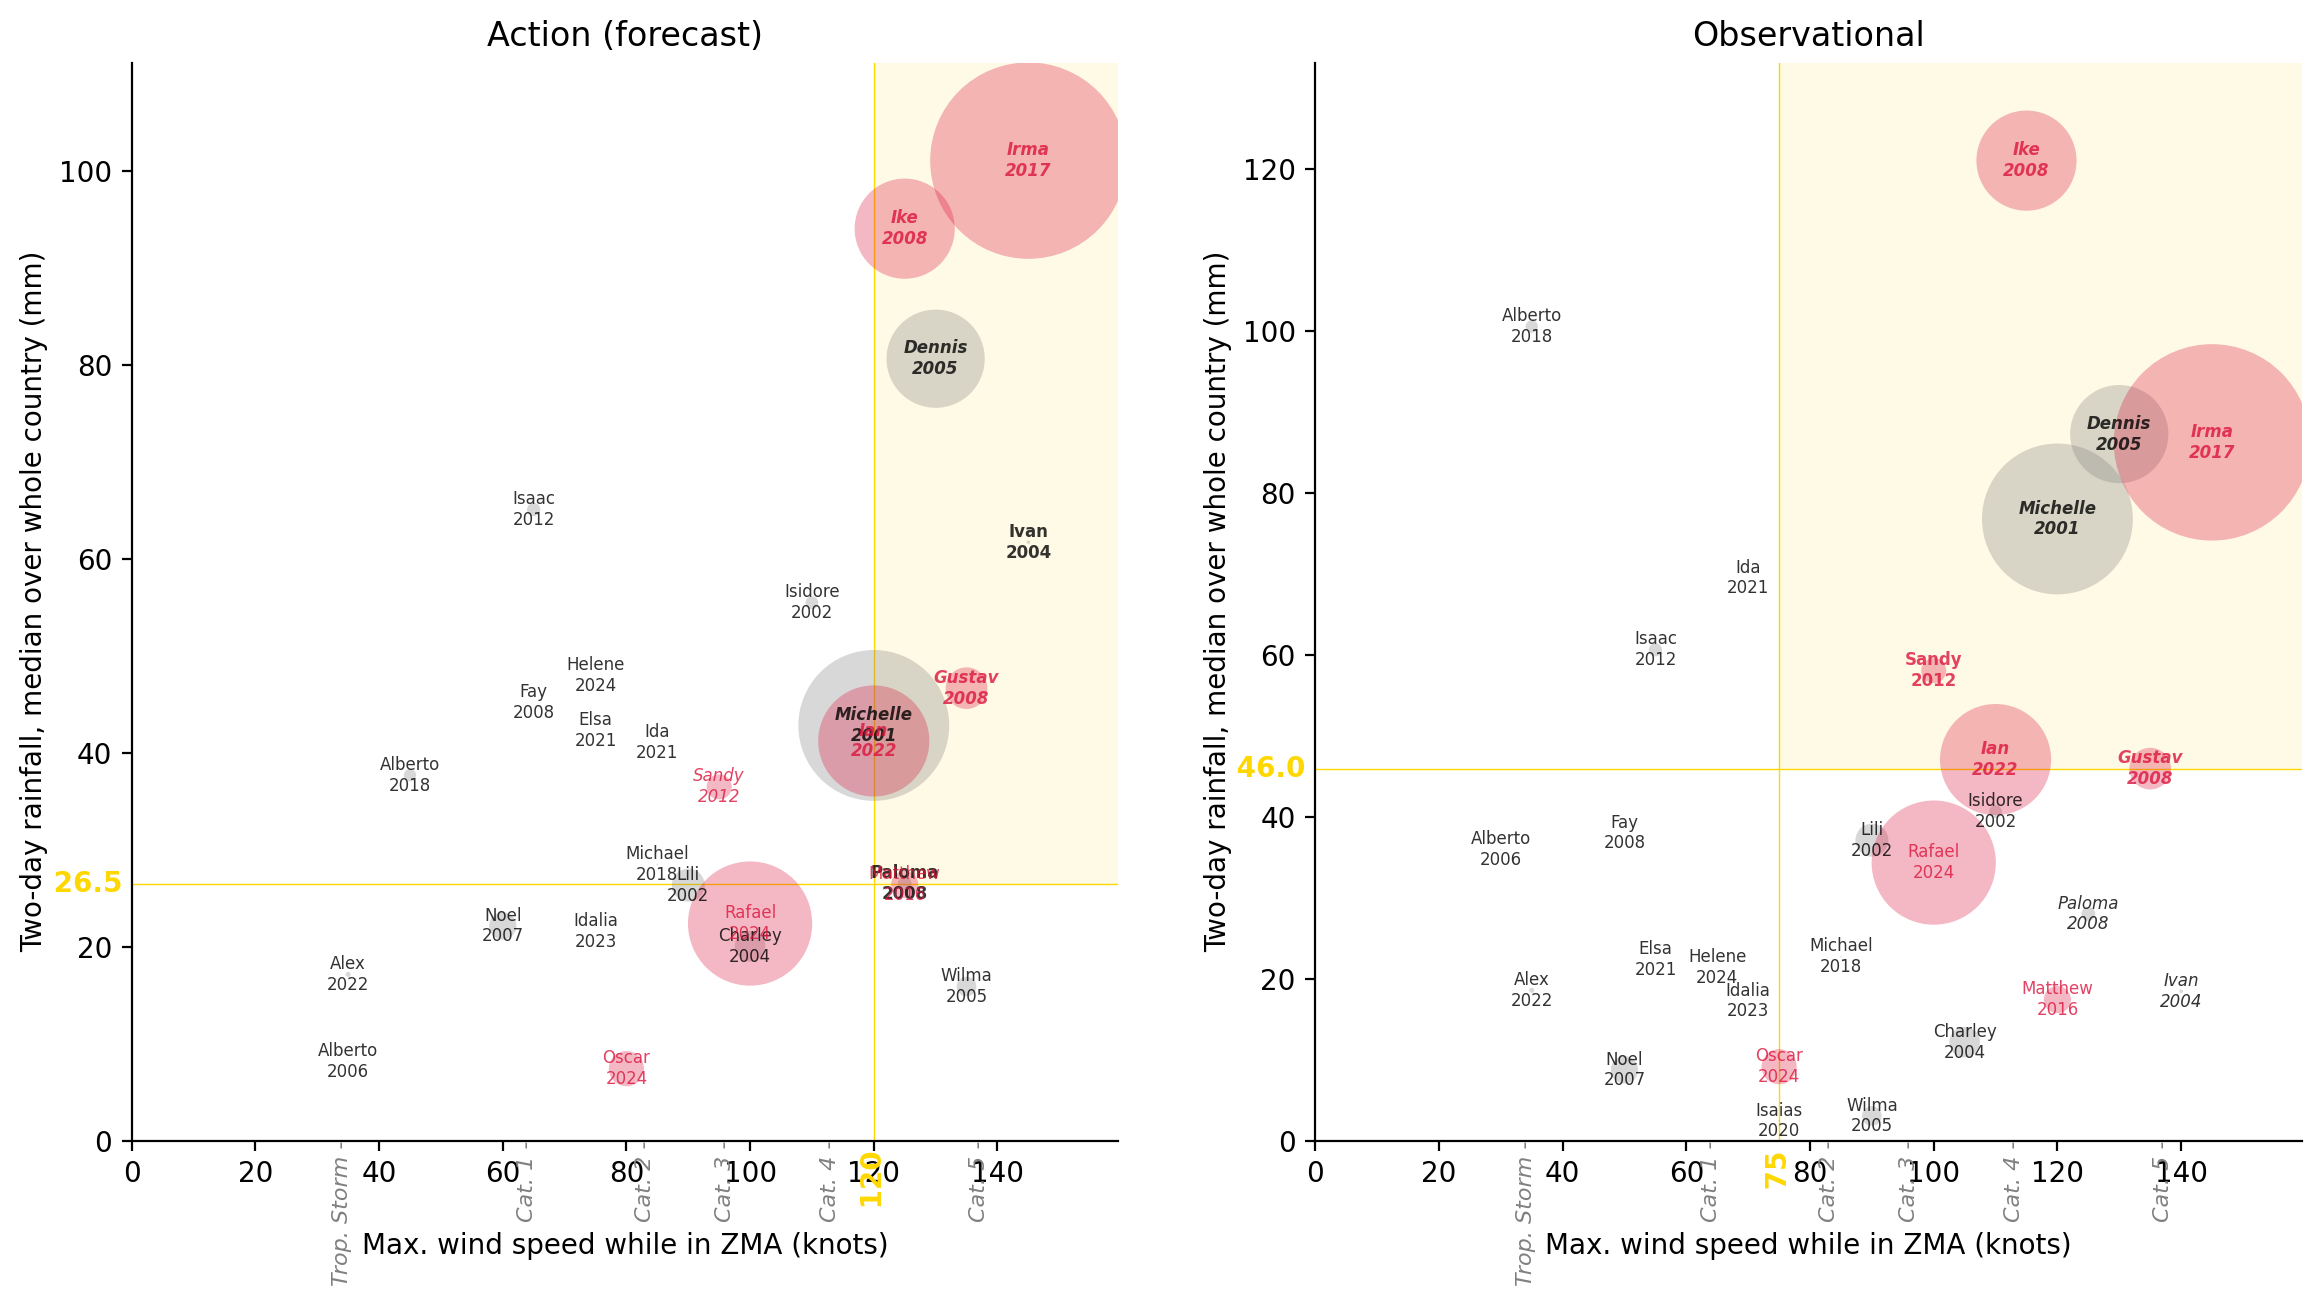

In [29]:
plot_selected_threshs(60832)

In [30]:
disp_selected_threshs(60832)

,Action,Obsv.,CERF,Total Affected
Storm,,,,
Irma 2017,Trig.,Trig.,Yes,"10,000,000"
Michelle 2001,Trig.,Trig.,pre-,"5,900,012"
Rafael 2024,No trig.,No trig.,Yes,"4,000,000"
Ian 2022,Trig.,Trig.,Yes,"3,200,000"
Ike 2008,Trig.,Trig.,Yes,"2,600,000"
Dennis 2005,Trig.,Trig.,pre-,"2,500,000"
Gustav 2008,Trig.,Trig.,Yes,"450,019"
Oscar 2024,No trig.,No trig.,Yes,"320,000"
Lili 2002,No trig.,No trig.,pre-,"281,470"


### Best Total Affected

Cluster (option 2 in slides) maximizing impact

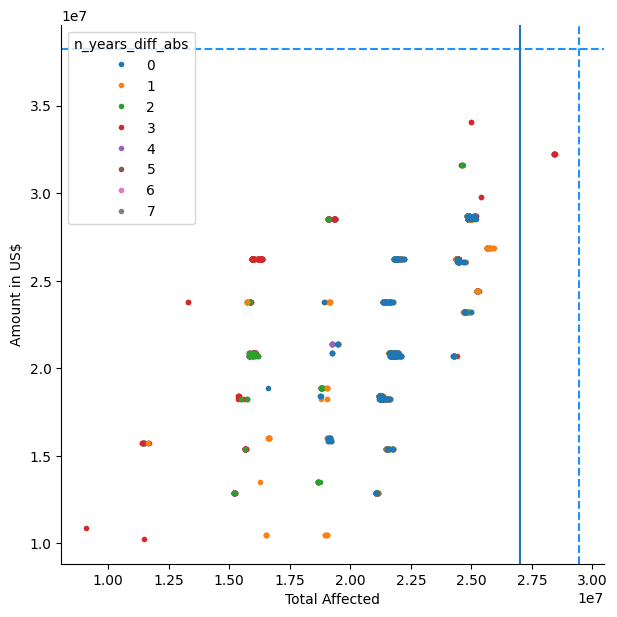

In [31]:
fig, ax = plot_thresh_scatter(
    "Total Affected", "Amount in US$", "n_years_diff_abs"
)
ax.axvline(2.7e7)

In [32]:
df_metrics_high_impact = df_metrics_lowest[
    df_metrics_lowest["Total Affected"] >= 2.7e7
]

In [33]:
df_metrics_high_impact

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
201131,28412062.0,52.0,4971882.0,32229929.0,5.0,35.0,mean,71.266540,75.0,q80_obsv,96.369003,4,7,-3,3,11
201388,28412062.0,52.0,4971882.0,32229929.0,5.0,35.0,q80,128.088730,75.0,q80_obsv,96.369003,3,7,-4,4,10
213486,28412062.0,52.0,4971882.0,32229929.0,5.0,NaN,q80,35.698547,75.0,q80_obsv,96.369003,0,7,-7,7,7
201218,28412062.0,52.0,4971882.0,32229929.0,5.0,35.0,q50,80.616330,75.0,q80_obsv,96.369003,3,7,-4,4,10
321926,28412062.0,52.0,4971882.0,32229929.0,5.0,75.0,q50,65.069570,75.0,q80_obsv,96.369003,3,7,-4,4,10
321743,28412062.0,52.0,4971882.0,32229929.0,5.0,75.0,mean,69.391884,75.0,q80_obsv,96.369003,4,7,-3,3,11
201286,28457558.0,53.0,4971882.0,32229929.0,5.0,35.0,q50,65.069570,75.0,q80_obsv,96.369003,4,7,-3,3,11
213390,28412062.0,52.0,4971882.0,32229929.0,5.0,NaN,q50,7.418959,75.0,q80_obsv,96.369003,0,7,-7,7,7
214074,28412062.0,52.0,4971882.0,32229929.0,5.0,NaN,q95,67.368840,75.0,q80_obsv,96.369003,0,7,-7,7,7
213054,28412062.0,52.0,4971882.0,32229929.0,5.0,NaN,mean,21.936502,75.0,q80_obsv,96.369003,0,7,-7,7,7


(<Figure size 2800x1400 with 2 Axes>,
 array([<Axes: title={'center': 'Action (forecast)'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, mean over whole country (mm)'>,
        <Axes: title={'center': 'Observational'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, 80th quantile over whole country (mm)'>],
       dtype=object))

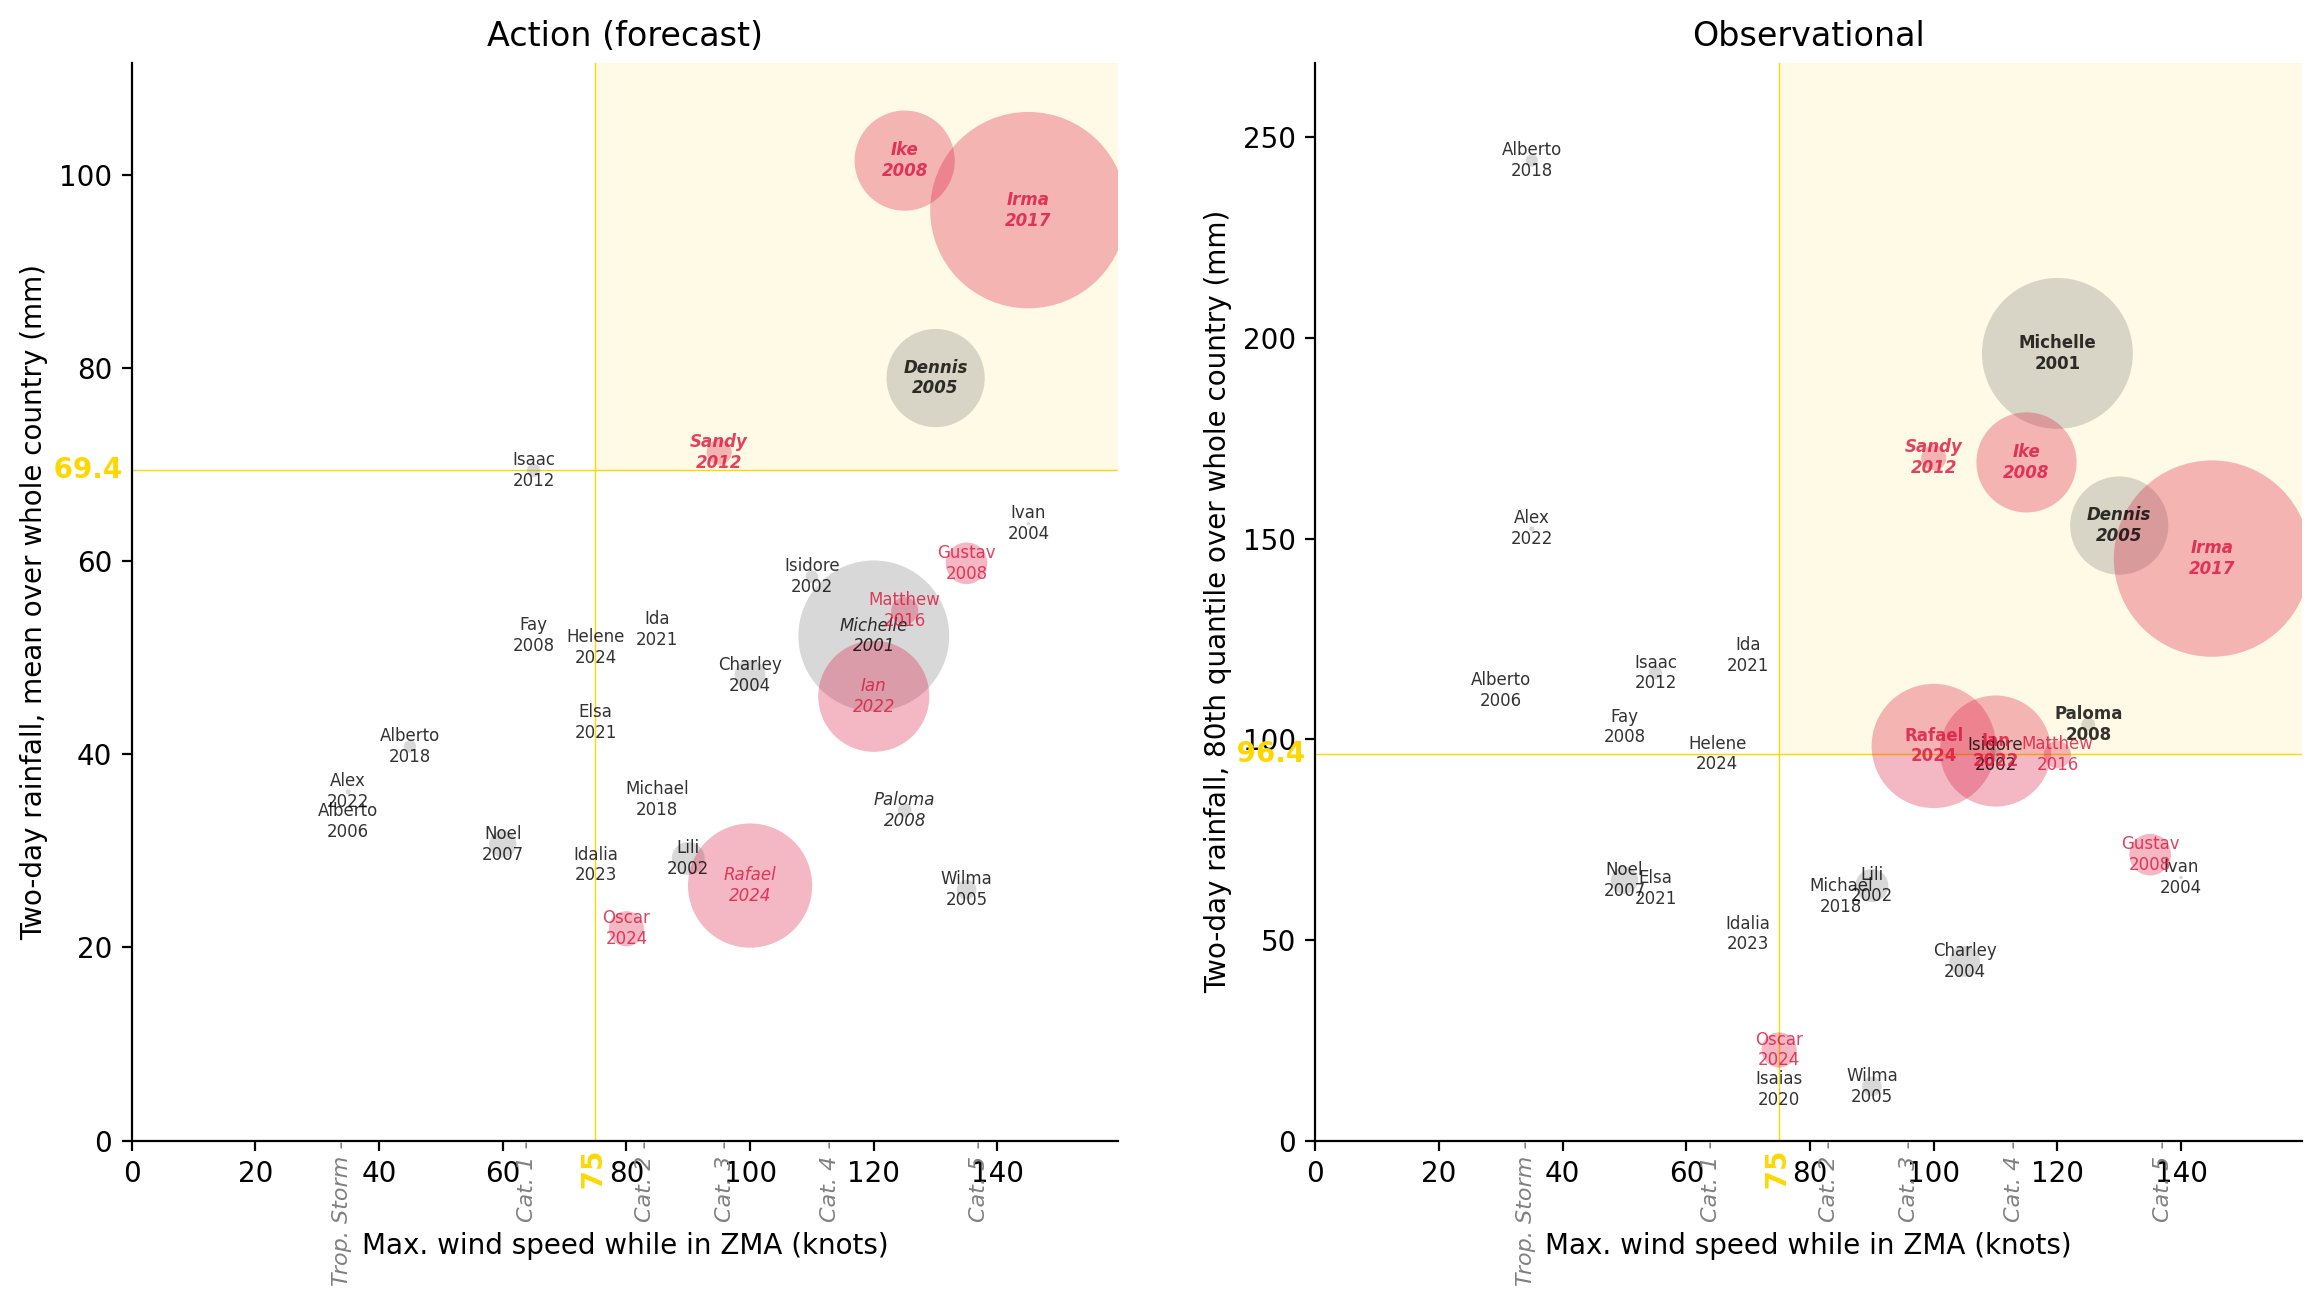

In [35]:
plot_selected_threshs(321743)

In [36]:
disp_selected_threshs(321743)

,Action,Obsv.,CERF,Total Affected
Storm,,,,
Irma 2017,Trig.,Trig.,Yes,"10,000,000"
Michelle 2001,No trig.,Trig.,pre-,"5,900,012"
Rafael 2024,No trig.,Trig.,Yes,"4,000,000"
Ian 2022,No trig.,Trig.,Yes,"3,200,000"
Ike 2008,Trig.,Trig.,Yes,"2,600,000"
Dennis 2005,Trig.,Trig.,pre-,"2,500,000"
Gustav 2008,No trig.,No trig.,Yes,"450,019"
Oscar 2024,No trig.,No trig.,Yes,"320,000"
Lili 2002,No trig.,No trig.,pre-,"281,470"


### Best CERF amount

Cluster (option 3 in slides) maximizing CERF amount

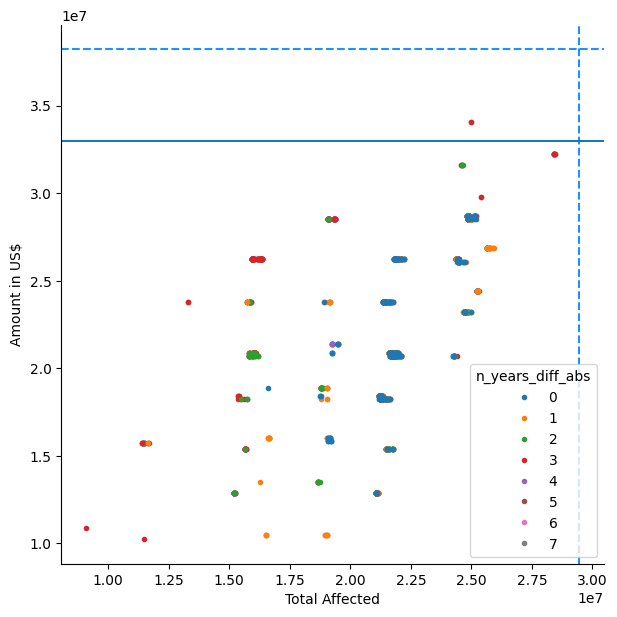

In [37]:
fig, ax = plot_thresh_scatter(
    "Total Affected", "Amount in US$", "n_years_diff_abs"
)
ax.axhline(3.3e7)

In [38]:
df_metrics_high_cerf = df_metrics_lowest[
    df_metrics_lowest["Amount in US$"] >= 3.3e7
]

In [39]:
df_metrics_high_cerf

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
201619,25002636.0,52.0,10958627.0,34070208.0,6.0,35.0,q95,241.6073,75.0,q50_obsv,45.957497,2,6,-4,4,8
91667,25002636.0,52.0,10958627.0,34070208.0,6.0,110.0,q95,177.1494,75.0,q50_obsv,45.957497,3,6,-3,3,9


(<Figure size 2800x1400 with 2 Axes>,
 array([<Axes: title={'center': 'Action (forecast)'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, 95th quantile over whole country (mm)'>,
        <Axes: title={'center': 'Observational'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, median over whole country (mm)'>],
       dtype=object))

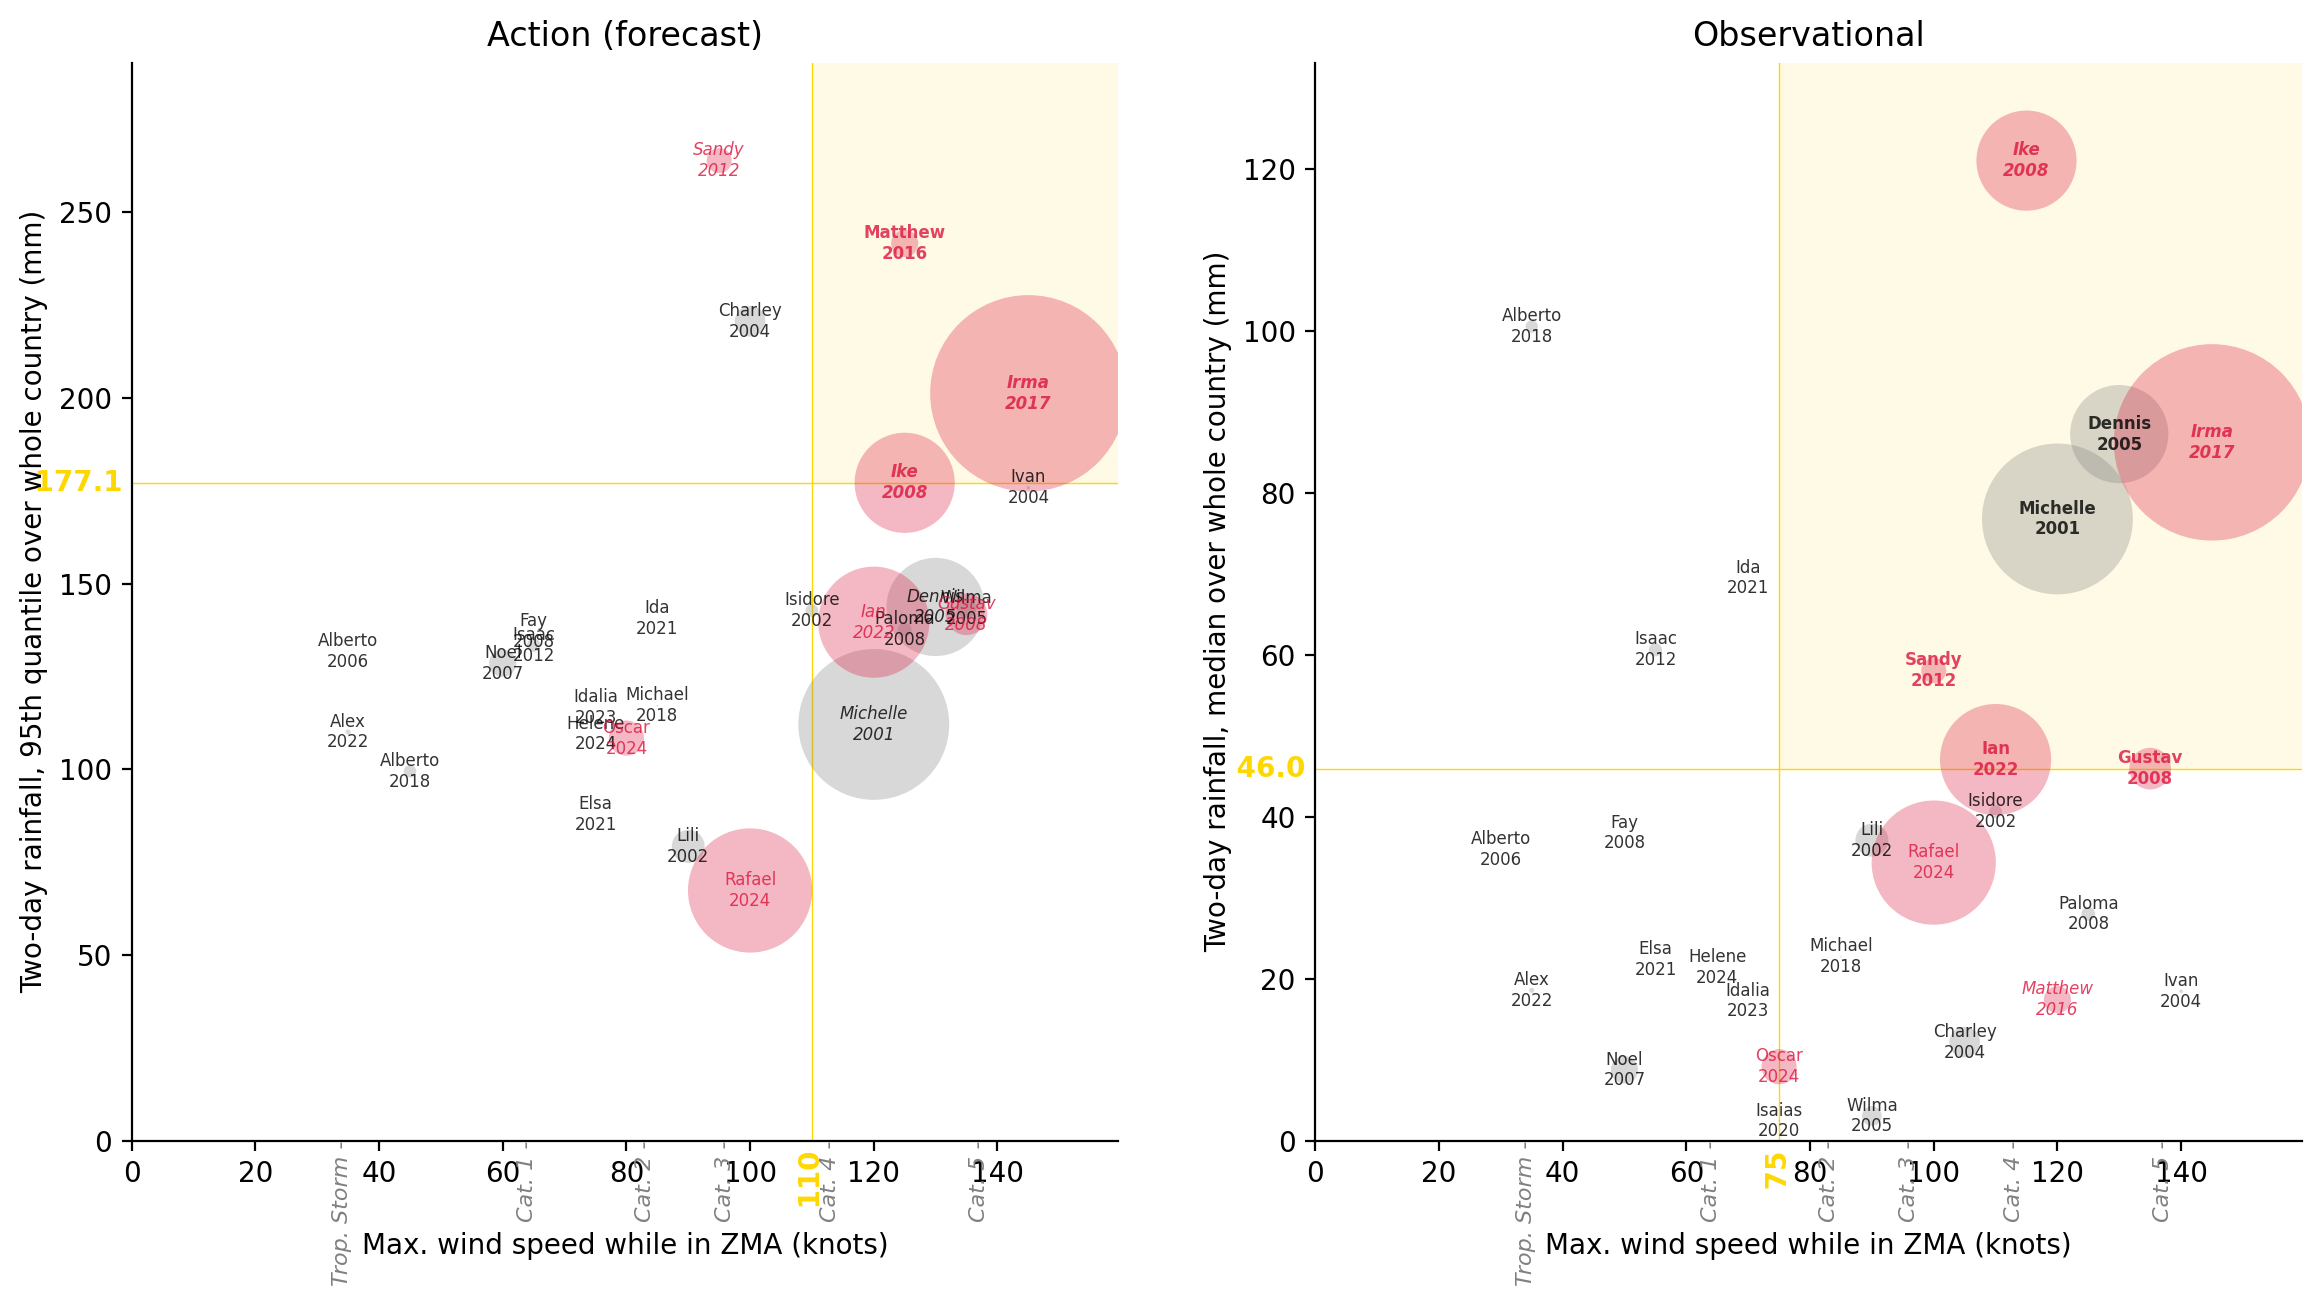

In [40]:
plot_selected_threshs(91667)

In [41]:
disp_selected_threshs(91667)

,Action,Obsv.,CERF,Total Affected
Storm,,,,
Irma 2017,Trig.,Trig.,Yes,"10,000,000"
Michelle 2001,No trig.,Trig.,pre-,"5,900,012"
Rafael 2024,No trig.,No trig.,Yes,"4,000,000"
Ian 2022,No trig.,Trig.,Yes,"3,200,000"
Ike 2008,Trig.,Trig.,Yes,"2,600,000"
Dennis 2005,No trig.,Trig.,pre-,"2,500,000"
Gustav 2008,No trig.,Trig.,Yes,"450,019"
Oscar 2024,No trig.,No trig.,Yes,"320,000"
Lili 2002,No trig.,No trig.,pre-,"281,470"


### Two years diff

Looking at that little cluster with a two-year difference. Doesn't look that remarkable, so left out of slides

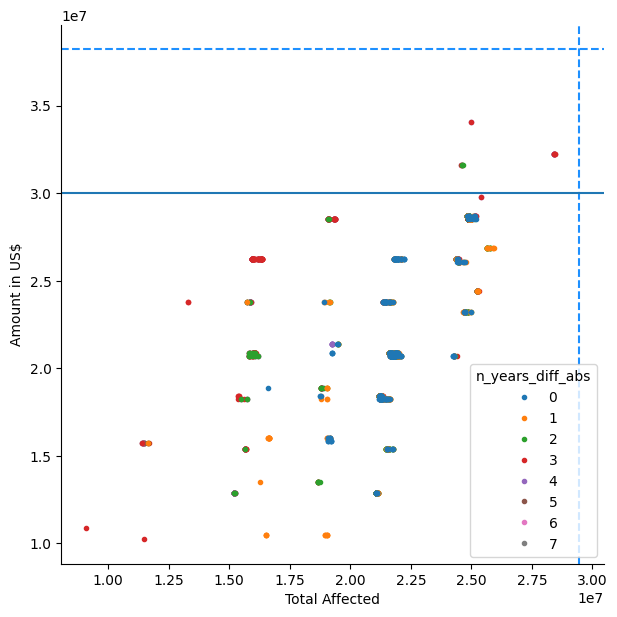

In [42]:
fig, ax = plot_thresh_scatter(
    "Total Affected", "Amount in US$", "n_years_diff_abs"
)
ax.axhline(3.0e7)

In [43]:
df_twoyears = df_metrics_lowest[
    (df_metrics_lowest["n_years_diff_abs"] == 2)
    & (df_metrics_lowest["Amount in US$"] >= 3.0e7)
]

In [44]:
df_twoyears

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
312998,24602062.0,52.0,8142214.0,31582777.0,5.0,75.0,mean,69.391884,105.0,q80_obsv,96.217003,4,6,-2,2,10
191213,24647558.0,53.0,8142214.0,31582777.0,5.0,35.0,mean,69.391884,105.0,q80_obsv,96.217003,4,6,-2,2,10
191235,24602062.0,52.0,8142214.0,31582777.0,5.0,35.0,mean,71.266540,105.0,q80_obsv,96.217003,4,6,-2,2,10


(<Figure size 2800x1400 with 2 Axes>,
 array([<Axes: title={'center': 'Action (forecast)'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, mean over whole country (mm)'>,
        <Axes: title={'center': 'Observational'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, 80th quantile over whole country (mm)'>],
       dtype=object))

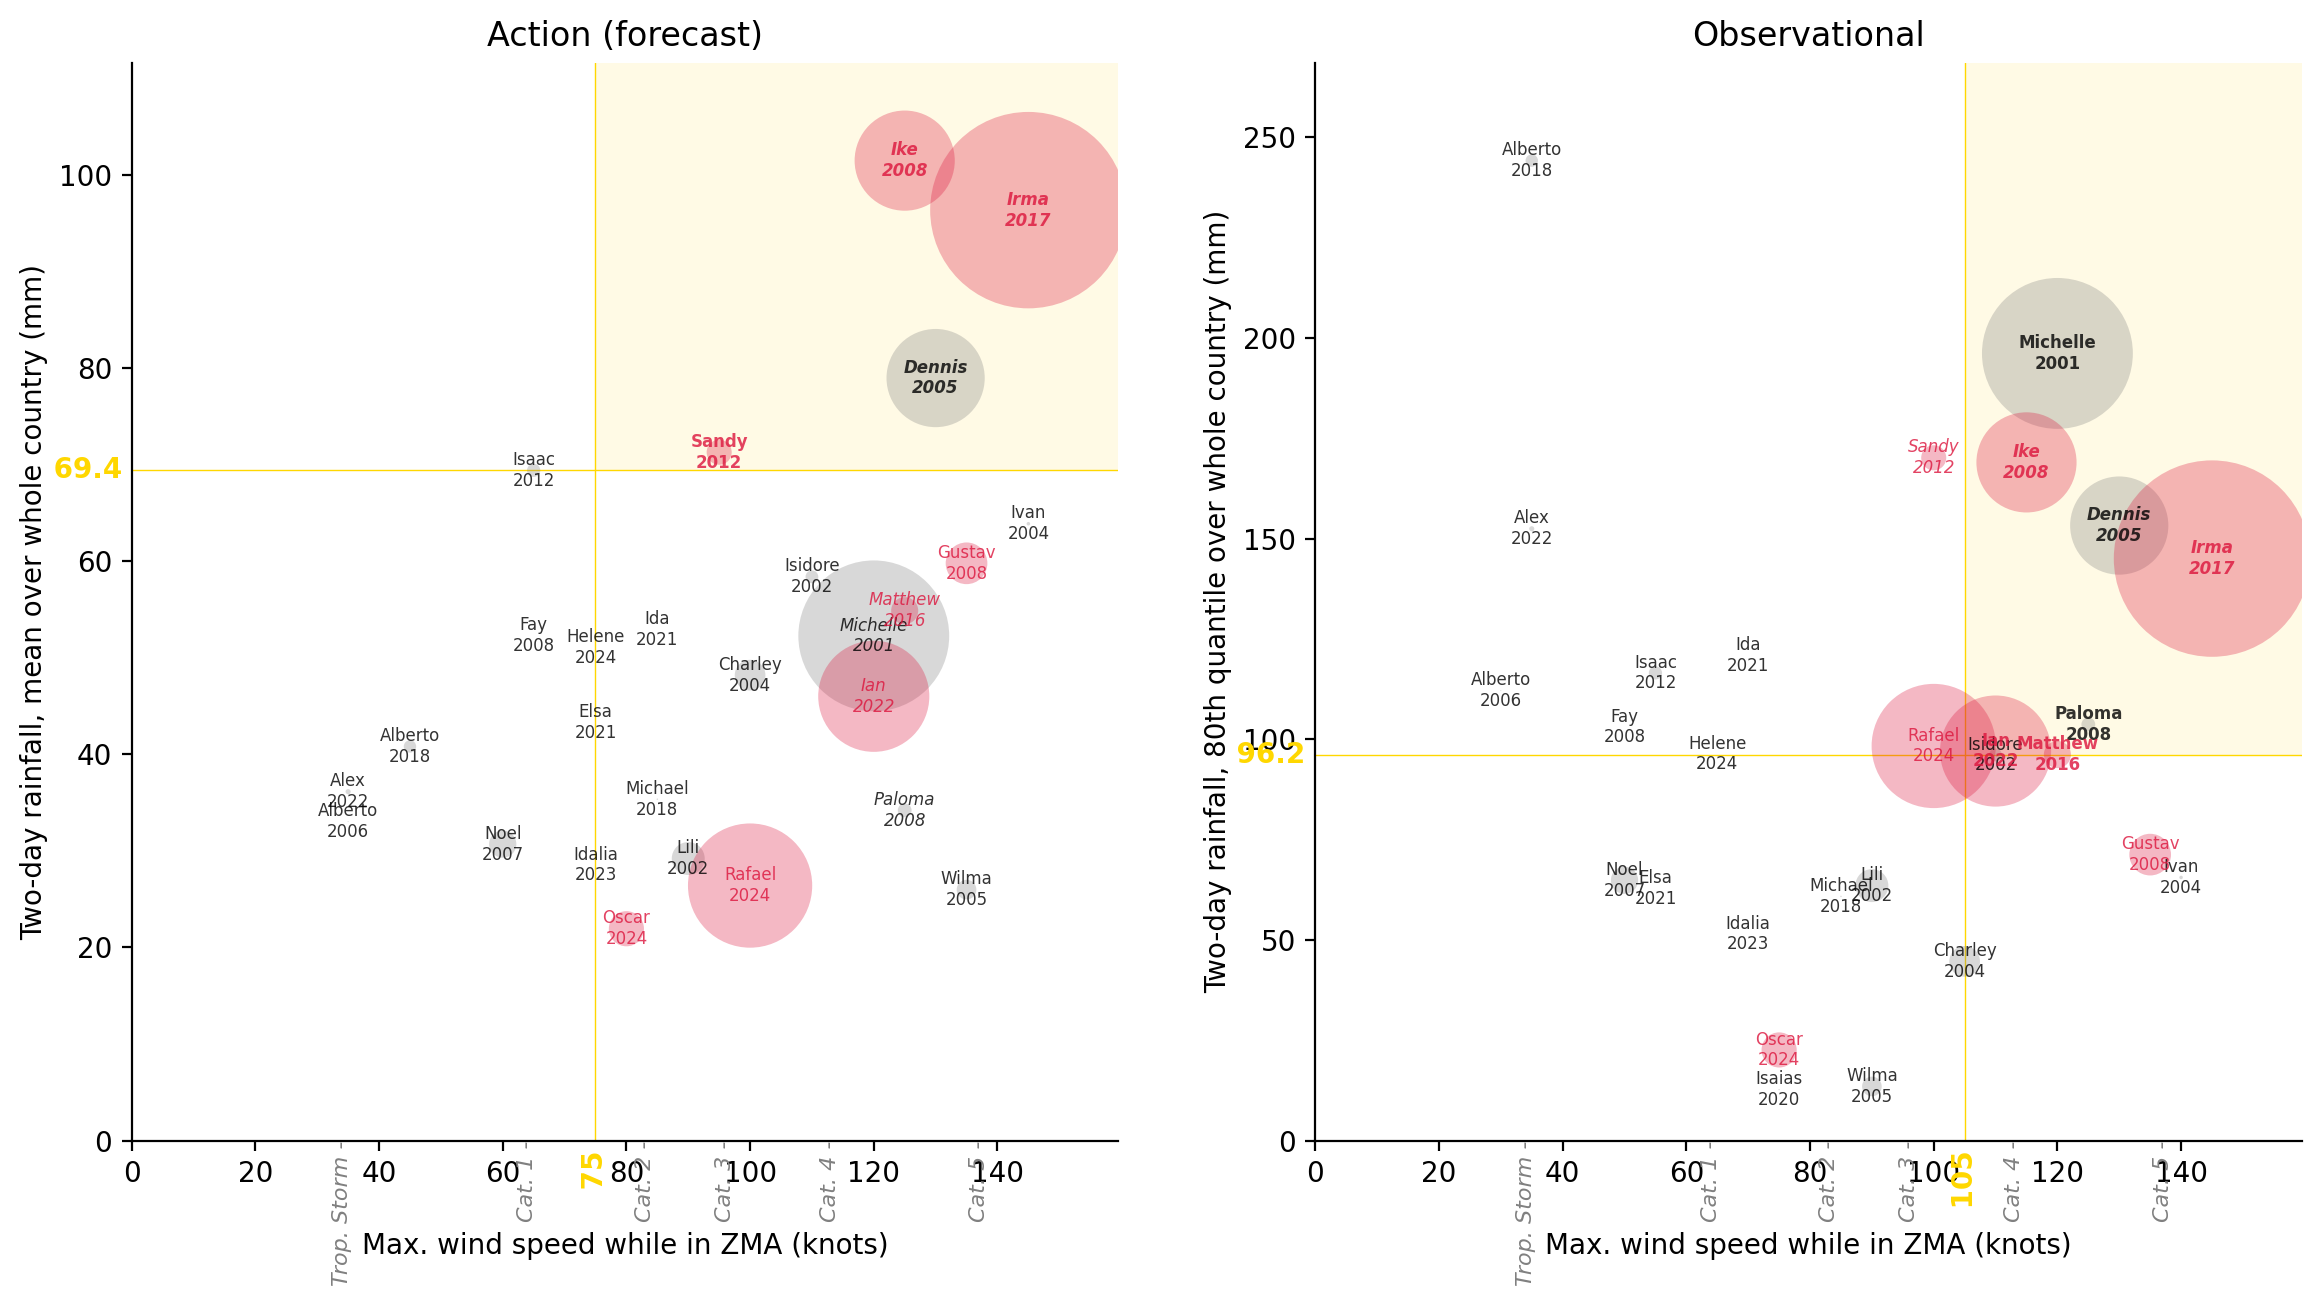

In [45]:
plot_selected_threshs(312998)

In [46]:
disp_selected_threshs(312998)

,Action,Obsv.,CERF,Total Affected
Storm,,,,
Irma 2017,Trig.,Trig.,Yes,"10,000,000"
Michelle 2001,No trig.,Trig.,pre-,"5,900,012"
Rafael 2024,No trig.,No trig.,Yes,"4,000,000"
Ian 2022,No trig.,Trig.,Yes,"3,200,000"
Ike 2008,Trig.,Trig.,Yes,"2,600,000"
Dennis 2005,Trig.,Trig.,pre-,"2,500,000"
Gustav 2008,No trig.,No trig.,Yes,"450,019"
Oscar 2024,No trig.,No trig.,Yes,"320,000"
Lili 2002,No trig.,No trig.,pre-,"281,470"


### One year diff

Small cluster with second-best total impact (option 4 in slides)

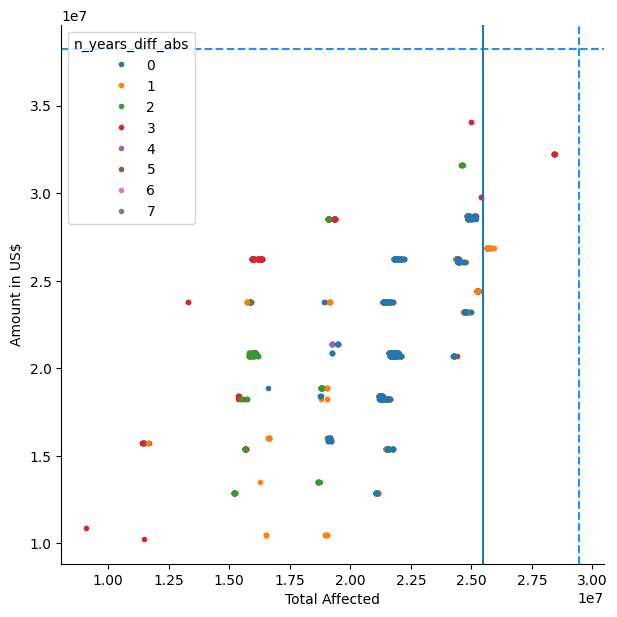

In [47]:
fig, ax = plot_thresh_scatter(
    "Total Affected", "Amount in US$", "n_years_diff_abs"
)
ax.axvline(2.55e7)

In [48]:
df_oneyear = df_metrics_lowest[
    (df_metrics_lowest["Total Affected"] >= 2.55e7)
    & (df_metrics_lowest["n_years_diff_abs"] == 1)
]

In [49]:
df_oneyear

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
201091,25710822.0,50.0,8073174.0,26889626.0,5.0,35.0,mean,59.768433,75.0,q80_obsv,98.341003,5,6,-1,1,11
201377,25710822.0,50.0,8073174.0,26889626.0,5.0,35.0,q80,103.080360,75.0,q80_obsv,98.341003,5,6,-1,1,11
111447,25909331.0,53.0,9622569.0,26889626.0,5.0,90.0,q80,87.754250,75.0,q80_obsv,98.341003,5,6,-1,1,11
60958,25665326.0,49.0,8073174.0,26889626.0,5.0,120.0,q50,42.302090,75.0,q80_obsv,98.341003,5,6,-1,1,11
322018,25665326.0,49.0,8073174.0,26889626.0,5.0,75.0,q80,103.080360,75.0,q80_obsv,98.341003,5,6,-1,1,11
321720,25665326.0,49.0,8073174.0,26889626.0,5.0,75.0,mean,59.768433,75.0,q80_obsv,98.341003,5,6,-1,1,11
201331,25954827.0,54.0,9622569.0,26889626.0,5.0,35.0,q80,96.462585,75.0,q80_obsv,98.341003,5,6,-1,1,11
321972,25909331.0,53.0,9622569.0,26889626.0,5.0,75.0,q80,96.462585,75.0,q80_obsv,98.341003,5,6,-1,1,11


(<Figure size 2800x1400 with 2 Axes>,
 array([<Axes: title={'center': 'Action (forecast)'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, 80th quantile over whole country (mm)'>,
        <Axes: title={'center': 'Observational'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, 80th quantile over whole country (mm)'>],
       dtype=object))

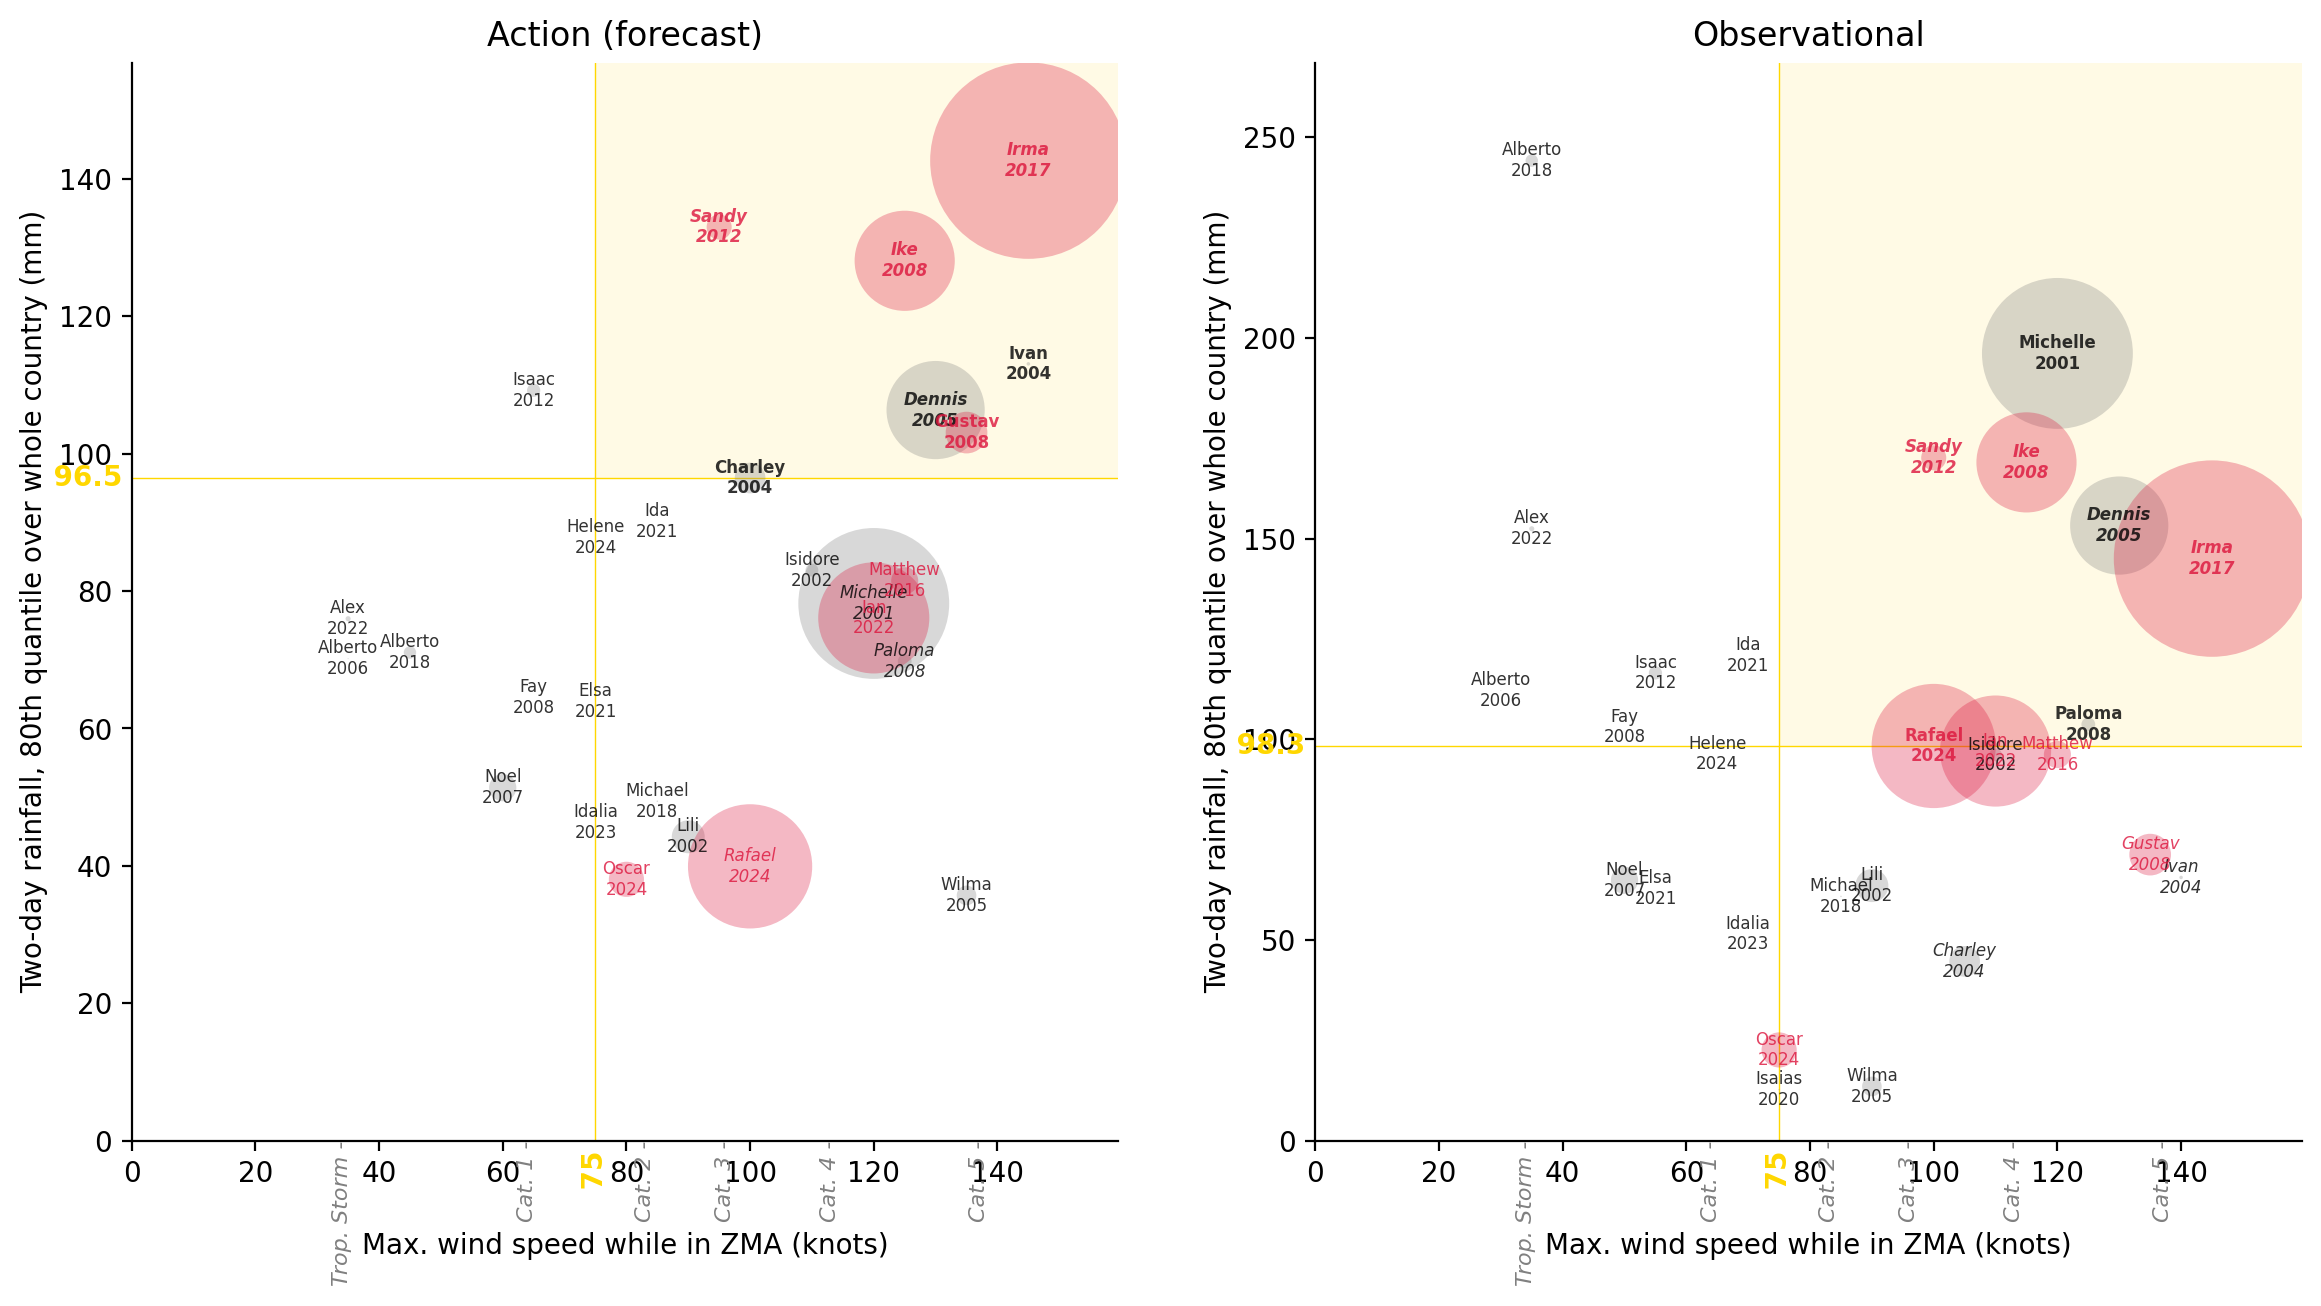

In [50]:
plot_selected_threshs(321972)

In [51]:
disp_selected_threshs(321972)

,Action,Obsv.,CERF,Total Affected
Storm,,,,
Irma 2017,Trig.,Trig.,Yes,"10,000,000"
Michelle 2001,No trig.,Trig.,pre-,"5,900,012"
Rafael 2024,No trig.,Trig.,Yes,"4,000,000"
Ian 2022,No trig.,No trig.,Yes,"3,200,000"
Ike 2008,Trig.,Trig.,Yes,"2,600,000"
Dennis 2005,Trig.,Trig.,pre-,"2,500,000"
Gustav 2008,Trig.,No trig.,Yes,"450,019"
Oscar 2024,No trig.,No trig.,Yes,"320,000"
Lili 2002,No trig.,No trig.,pre-,"281,470"


### Forecast preference

Looking at how we can tilt probability even more towards forecast - basically just variants of option 1

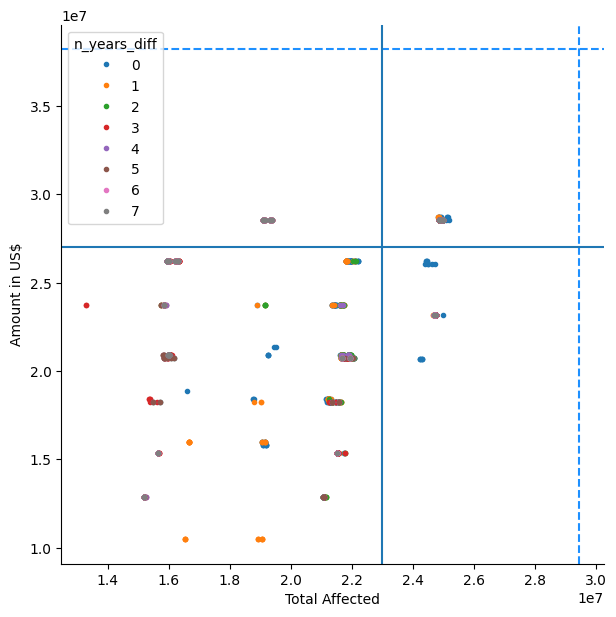

In [52]:
fig, ax = plot_thresh_scatter(
    "Total Affected",
    "Amount in US$",
    "n_years_diff",
    fcast_pref_only=True,
    zorder_rev=False,
)
ax.axhline(2.7e7)
ax.axvline(2.3e7)

In [53]:
df_fcast_pref = df_metrics_lowest[
    (df_metrics_lowest["Total Affected"] >= 2.3e7)
    & (df_metrics_lowest["Amount in US$"] >= 2.7e7)
    & (df_metrics_lowest["n_years_diff"] >= 0)
]

In [54]:
df_fcast_pref

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
22746,24843276.0,41.0,11268506.0,28547455.0,5.0,120.0,q80,70.166730,130.0,q50_obsv,2.44,7,4,3,3,11
38993,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,mean,21.936502,115.0,q50_obsv,2.44,7,6,1,1,13
44003,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,q95,67.368840,115.0,q50_obsv,2.44,7,6,1,1,13
39109,24892721.0,41.0,11268506.0,28547455.0,5.0,120.0,mean,26.405380,115.0,q50_obsv,2.44,7,6,1,1,13
42119,24892721.0,41.0,11268506.0,28547455.0,5.0,120.0,q80,38.042336,115.0,q50_obsv,2.44,7,6,1,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25792,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,q95,67.368840,30.0,q95_obsv,NaN,7,0,7,7,7
25421,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,q50,7.418959,30.0,q80_obsv,NaN,7,0,7,7,7
25422,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,q50,7.418959,30.0,q95_obsv,NaN,7,0,7,7,7
25202,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,mean,21.936502,30.0,q80_obsv,NaN,7,0,7,7,7


In [55]:
df_fcast_only = df_fcast_pref[df_fcast_pref["n_years_diff"] == 0]

In [56]:
df_fcast_only

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
71389,24843276.0,41.0,11268506.0,28547455.0,5.0,110.0,q95,143.712340,105.0,q50_obsv,45.957497,5,5,0,0,10
119458,25087281.0,45.0,12817901.0,28547455.0,5.0,100.0,q95,143.712340,105.0,q50_obsv,45.957497,5,5,0,0,10
119486,25187281.0,49.0,13866888.0,28547455.0,5.0,100.0,q95,143.409800,105.0,q50_obsv,45.957497,5,5,0,0,10
71417,24943276.0,45.0,12317493.0,28547455.0,5.0,110.0,q95,143.409800,105.0,q50_obsv,45.957497,5,5,0,0,10
60832,24865326.0,52.0,8098174.0,28717472.0,5.0,120.0,q50,26.483074,75.0,q50_obsv,45.957497,6,6,0,0,12
60935,24815881.0,52.0,8098174.0,28717472.0,5.0,120.0,q50,28.462177,75.0,q50_obsv,45.957497,6,6,0,0,12
191429,25154827.0,57.0,9647569.0,28717472.0,5.0,35.0,q80,96.462585,105.0,q80_obsv,96.369003,5,5,0,0,10
98070,25109331.0,56.0,9647569.0,28717472.0,5.0,90.0,q80,87.754250,105.0,q80_obsv,96.369003,5,5,0,0,10
313372,24865326.0,52.0,8098174.0,28717472.0,5.0,75.0,q80,103.080360,105.0,q80_obsv,96.369003,5,5,0,0,10
191479,24910822.0,53.0,8098174.0,28717472.0,5.0,35.0,q80,103.080360,105.0,q80_obsv,96.369003,5,5,0,0,10


(<Figure size 2800x1400 with 2 Axes>,
 array([<Axes: title={'center': 'Action (forecast)'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, 80th quantile over whole country (mm)'>,
        <Axes: title={'center': 'Observational'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, 80th quantile over whole country (mm)'>],
       dtype=object))

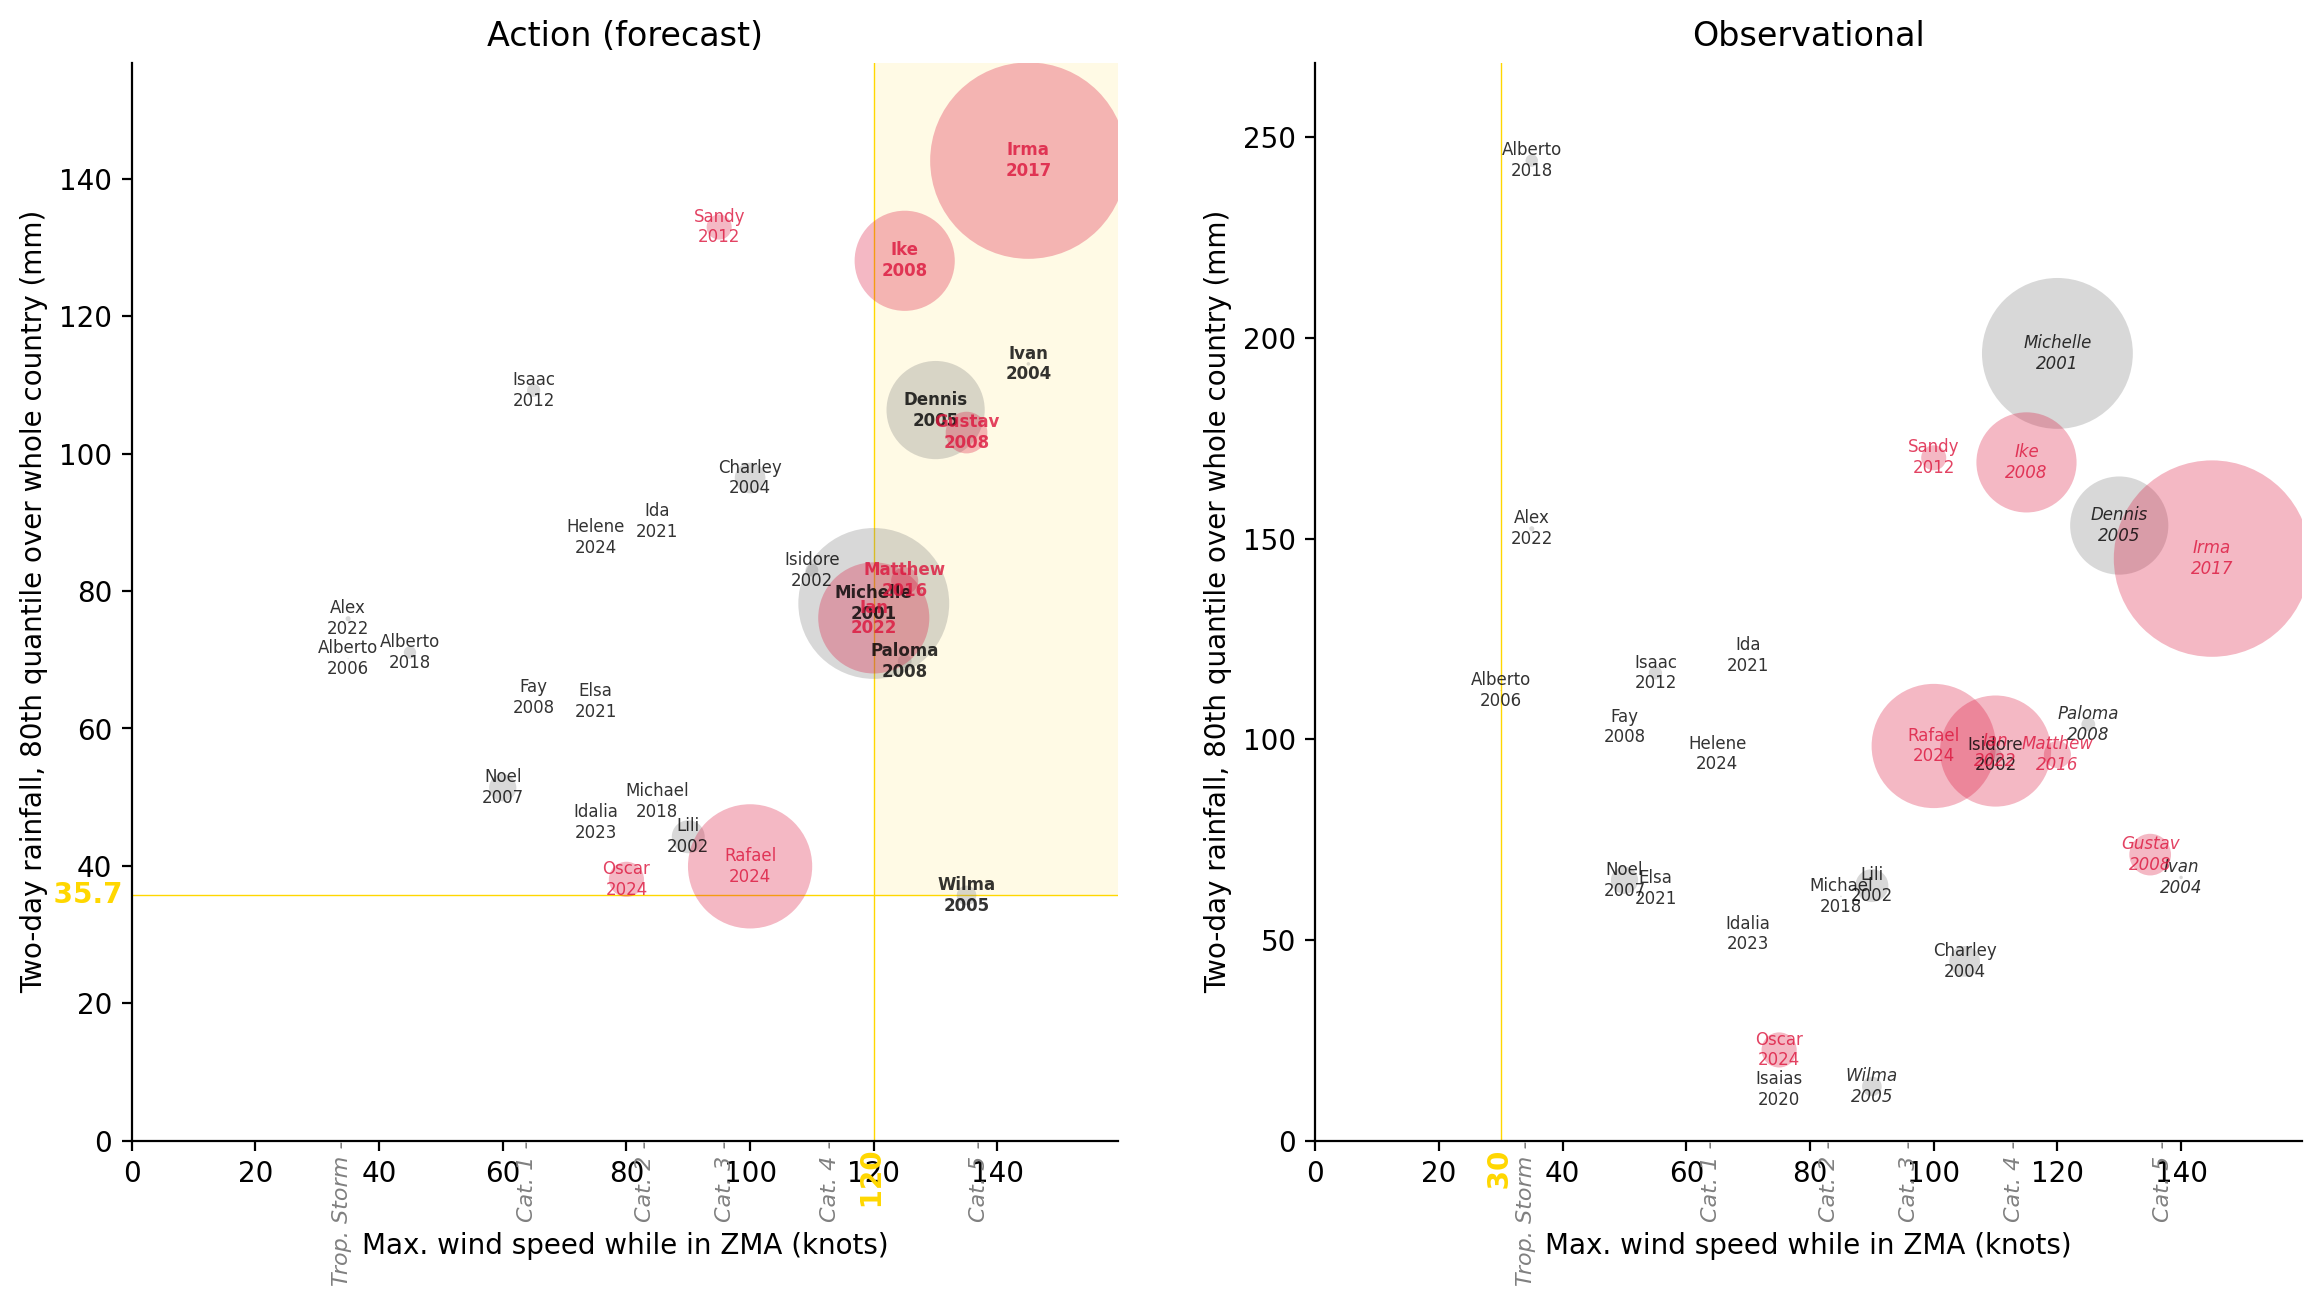

In [57]:
plot_selected_threshs(25477)

### Simplified triggers

Keeping only options with same rainfall aggregation, and same windspeed across forecast and observational

In [58]:
df_simplified = df_metrics_lowest[
    (
        df_metrics_lowest["fcast_rain_col"]
        == df_metrics_lowest["obsv_rain_col"].str.removesuffix("_obsv")
    )
    & (df_metrics_lowest["fcast_wind"] == df_metrics_lowest["obsv_wind"])
]

In [65]:
df_metrics_lowest[
    (df_metrics_lowest["fcast_wind"] == df_metrics_lowest["obsv_wind"])
].sort_values("Total Affected", ascending=False)

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
321743,28412062.0,52.0,4971882.0,32229929.0,5.0,75.0,mean,69.391884,75.0,q80_obsv,96.369003,4,7,-3,3,11
321926,28412062.0,52.0,4971882.0,32229929.0,5.0,75.0,q50,65.069570,75.0,q80_obsv,96.369003,3,7,-4,4,10
321972,25909331.0,53.0,9622569.0,26889626.0,5.0,75.0,q80,96.462585,75.0,q80_obsv,98.341003,5,6,-1,1,11
322018,25665326.0,49.0,8073174.0,26889626.0,5.0,75.0,q80,103.080360,75.0,q80_obsv,98.341003,5,6,-1,1,11
321720,25665326.0,49.0,8073174.0,26889626.0,5.0,75.0,mean,59.768433,75.0,q80_obsv,98.341003,5,6,-1,1,11
321846,25215307.0,49.0,5256761.0,24402195.0,4.0,75.0,q50,61.708008,75.0,q80_obsv,98.341003,4,6,-2,2,10
321994,25215307.0,49.0,5256761.0,24402195.0,4.0,75.0,q80,106.357285,75.0,q80_obsv,98.341003,5,6,-1,1,11
321679,25215307.0,49.0,5256761.0,24402195.0,4.0,75.0,mean,63.864970,75.0,q80_obsv,98.341003,5,6,-1,1,11
321923,25136606.0,55.0,7863137.0,28717472.0,5.0,75.0,q50,65.069570,75.0,q50_obsv,35.949997,3,7,-4,4,10
321740,25136606.0,55.0,7863137.0,28717472.0,5.0,75.0,mean,69.391884,75.0,q50_obsv,35.949997,4,7,-3,3,11


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='Total Affected', ylabel='Amount in US$'>)

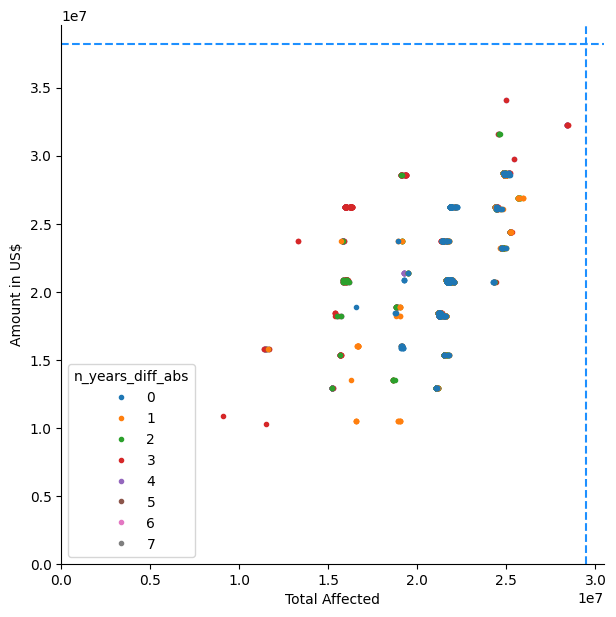

In [70]:
plot_thresh_scatter(
    "Total Affected",
    "Amount in US$",
    color="n_years_diff_abs",
    zero_intercept=True,
)

(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='Total Affected', ylabel='Amount in US$'>)

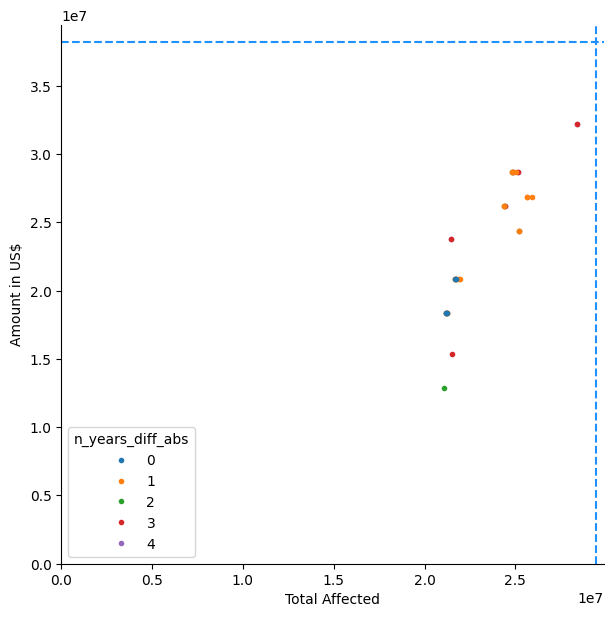

In [69]:
plot_thresh_scatter(
    "Total Affected",
    "Amount in US$",
    color="n_years_diff_abs",
    same_wind=True,
    zero_intercept=True,
)

(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='Total Affected', ylabel='Amount in US$'>)

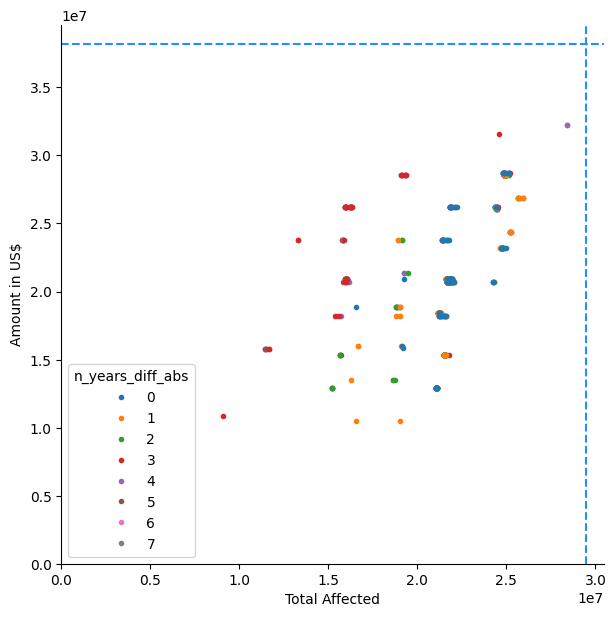

In [72]:
plot_thresh_scatter(
    "Total Affected",
    "Amount in US$",
    color="n_years_diff_abs",
    same_rain_col=True,
    zero_intercept=True,
)

(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='Total Affected', ylabel='Amount in US$'>)

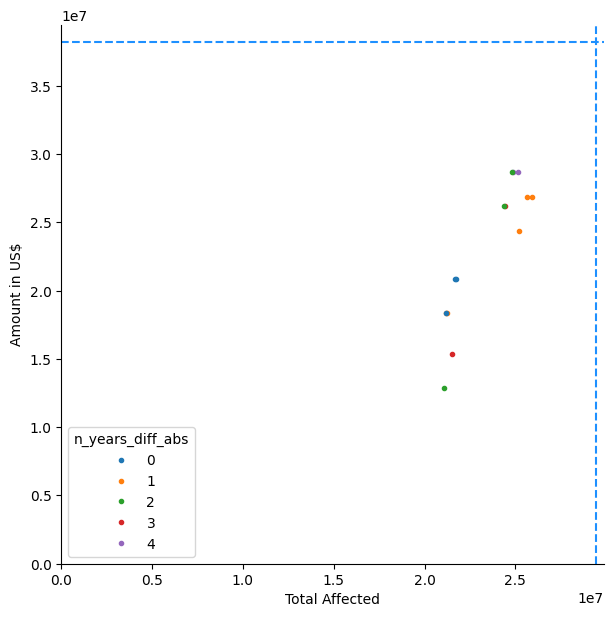

In [74]:
plot_thresh_scatter(
    "Total Affected",
    "Amount in US$",
    color="n_years_diff_abs",
    same_rain_col=True,
    same_wind=True,
    zero_intercept=True,
)

In [70]:
df_metrics_lowest[df_metrics_lowest[]]

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
332720,24745221.0,41.0,8135595.0,23194719.0,4.0,80.0,q50,41.205720,125.0,q50_obsv,2.44,7,4,3,3,11
198088,16341819.0,52.0,13714030.0,26242474.0,5.0,35.0,q95,141.738710,125.0,q50_obsv,2.44,7,4,3,3,11
22746,24843276.0,41.0,11268506.0,28547455.0,5.0,120.0,q80,70.166730,130.0,q50_obsv,2.44,7,4,3,3,11
82763,21735221.0,38.0,11280927.0,20719721.0,4.0,110.0,q80,78.203220,115.0,q50_obsv,2.44,7,6,1,1,13
314406,21495776.0,38.0,8110595.0,15366985.0,3.0,75.0,q50,42.807594,130.0,q50_obsv,2.44,7,4,3,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25202,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,mean,21.936502,30.0,q80_obsv,NaN,7,0,7,7,7
25203,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,mean,21.936502,30.0,q95_obsv,NaN,7,0,7,7,7
100940,16292374.0,52.0,13714030.0,26242474.0,5.0,90.0,q95,140.547760,30.0,mean_obsv,NaN,7,0,7,7,7
100943,16292374.0,52.0,13714030.0,26242474.0,5.0,90.0,q95,140.547760,30.0,q80_obsv,NaN,7,0,7,7,7


In [80]:
df_simplified.sort_values(
    ["Amount in US$", "Total Affected"],
    ascending=False,
)

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
321923,25136606.0,55.0,7863137.0,28717472.0,5.0,75.0,q50,65.069570,75.0,q50_obsv,35.949997,3,7,-4,4,10
321924,24855136.0,52.0,7825716.0,28717472.0,5.0,75.0,q50,65.069570,75.0,q50_obsv,38.012497,3,7,-4,4,10
321844,24815881.0,52.0,8098174.0,28717472.0,5.0,75.0,q50,61.708008,75.0,q50_obsv,45.957497,4,6,-2,2,10
321972,25909331.0,53.0,9622569.0,26889626.0,5.0,75.0,q80,96.462585,75.0,q80_obsv,98.341003,5,6,-1,1,11
322018,25665326.0,49.0,8073174.0,26889626.0,5.0,75.0,q80,103.080360,75.0,q80_obsv,98.341003,5,6,-1,1,11
321737,24454562.0,52.0,5009303.0,26230041.0,4.0,75.0,mean,69.391884,75.0,mean_obsv,51.583454,4,7,-3,3,11
321845,24365862.0,52.0,5281761.0,26230041.0,4.0,75.0,q50,61.708008,75.0,q50_obsv,47.079998,4,6,-2,2,10
321994,25215307.0,49.0,5256761.0,24402195.0,4.0,75.0,q80,106.357285,75.0,q80_obsv,98.341003,5,6,-1,1,11
321644,21707826.0,49.0,8110595.0,20889738.0,4.0,75.0,mean,58.365227,75.0,mean_obsv,55.230145,6,6,0,0,12
321647,21658381.0,49.0,8110595.0,20889738.0,4.0,75.0,mean,58.365227,75.0,mean_obsv,74.488056,6,6,0,0,12


(<Figure size 2800x1400 with 2 Axes>,
 array([<Axes: title={'center': 'Action (forecast)'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, median over whole country (mm)'>,
        <Axes: title={'center': 'Observational'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, median over whole country (mm)'>],
       dtype=object))

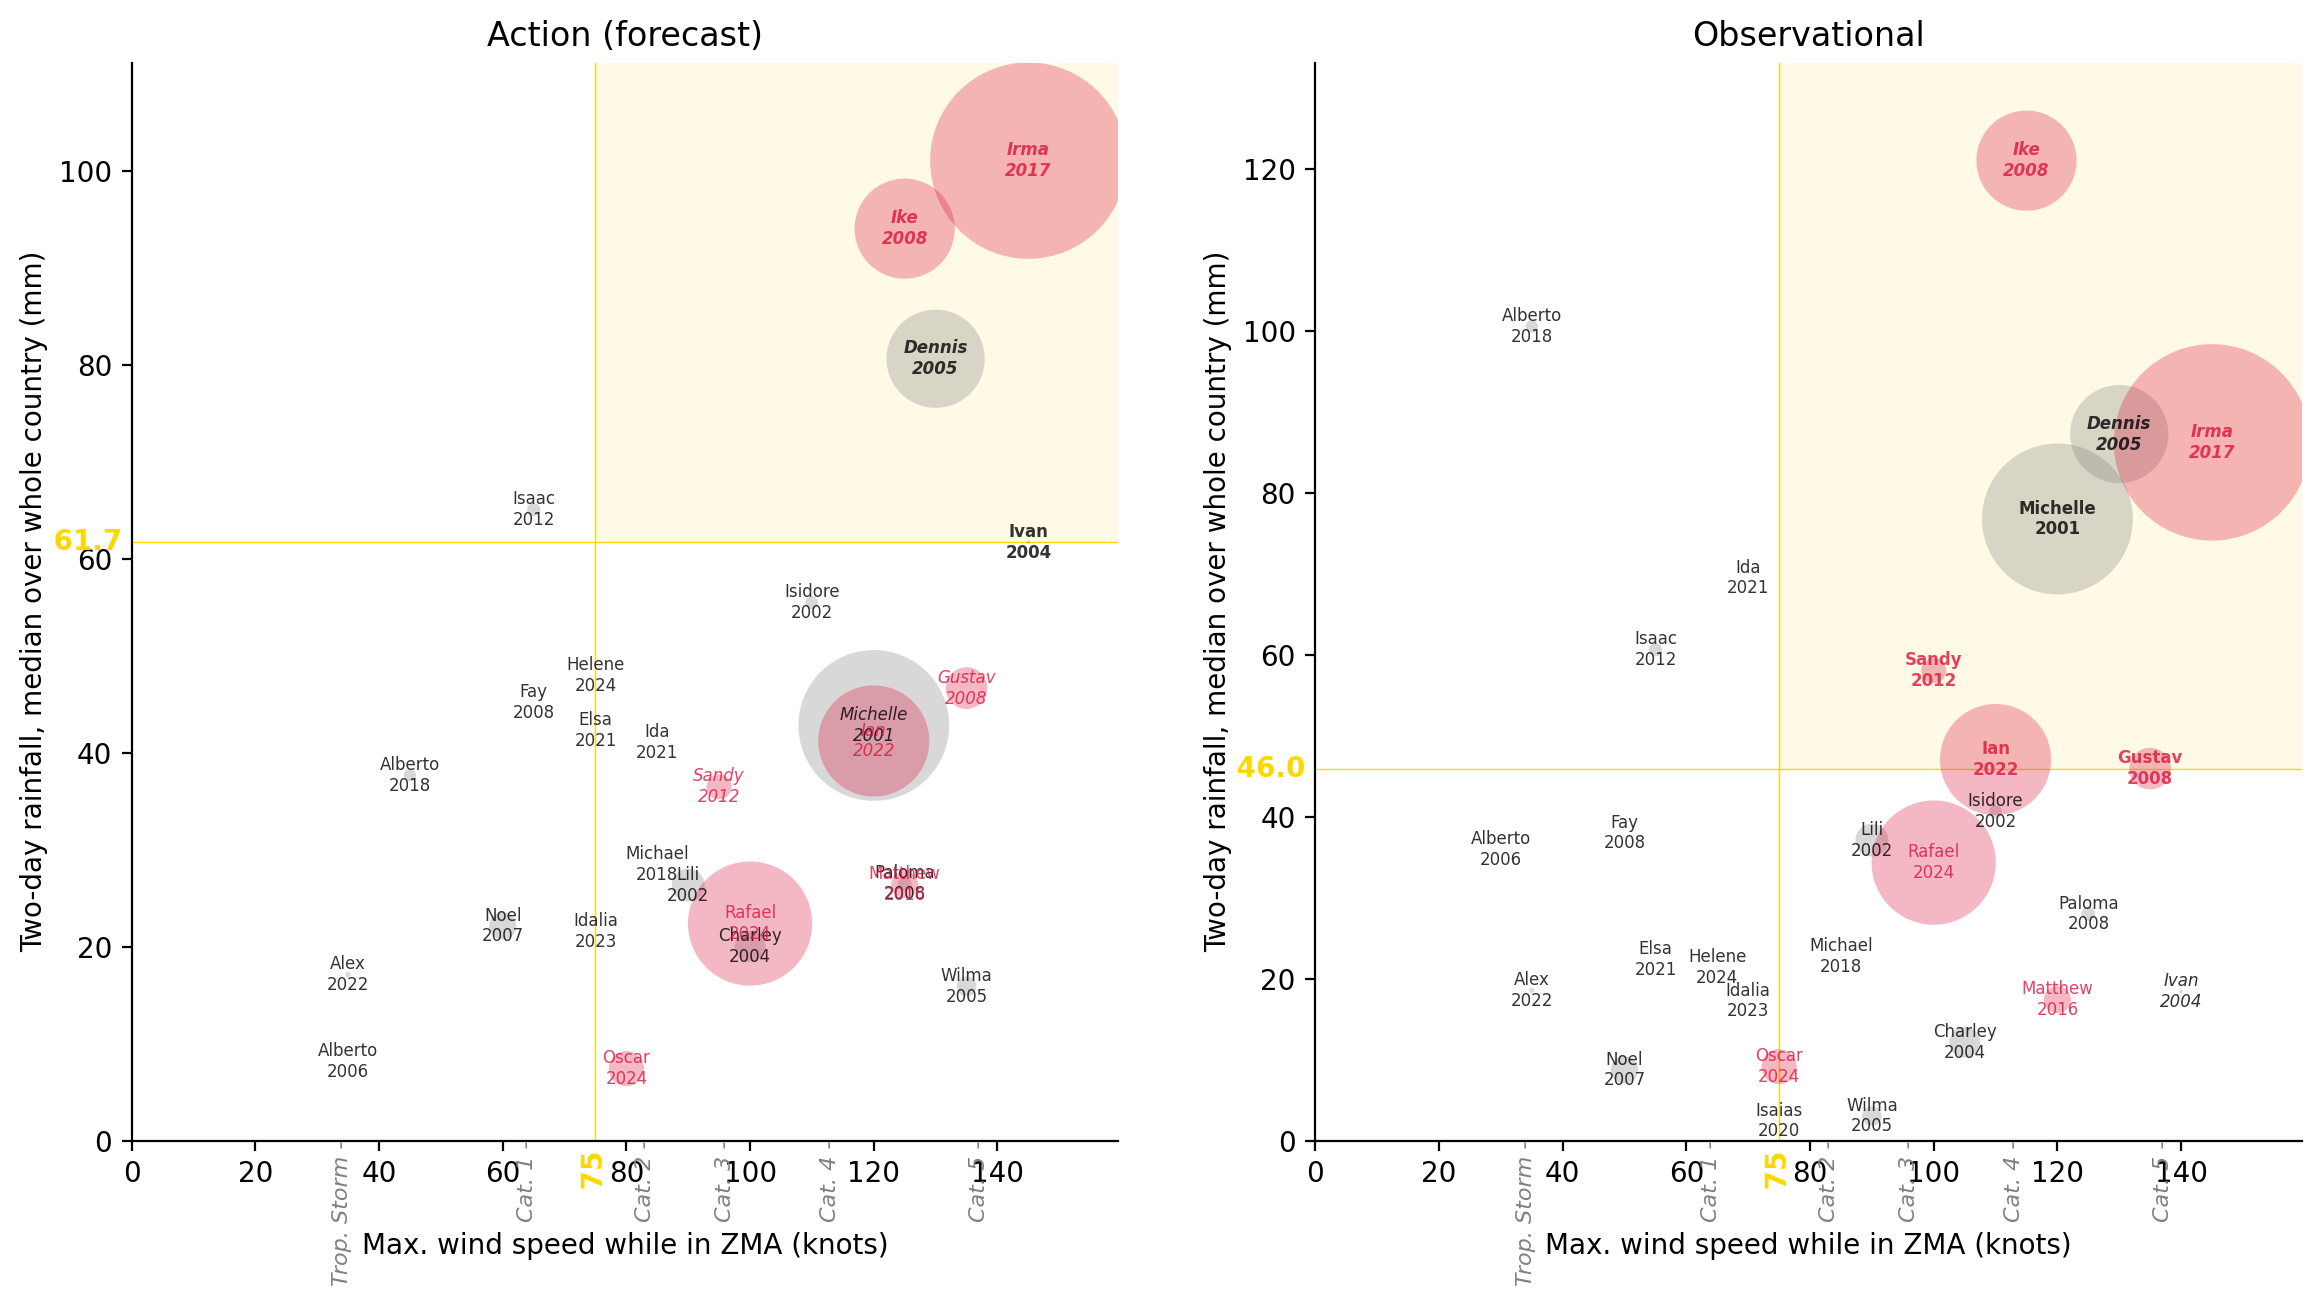

In [85]:
plot_selected_threshs(321844)

In [86]:
disp_selected_threshs(321844)

,Action,Obsv.,CERF,Total Affected
Storm,,,,
Irma 2017,Trig.,Trig.,Yes,"10,000,000"
Michelle 2001,No trig.,Trig.,pre-,"5,900,012"
Rafael 2024,No trig.,No trig.,Yes,"4,000,000"
Ian 2022,No trig.,Trig.,Yes,"3,200,000"
Ike 2008,Trig.,Trig.,Yes,"2,600,000"
Dennis 2005,Trig.,Trig.,pre-,"2,500,000"
Gustav 2008,No trig.,Trig.,Yes,"450,019"
Oscar 2024,No trig.,No trig.,Yes,"320,000"
Lili 2002,No trig.,No trig.,pre-,"281,470"


In [87]:
df_metrics_lowest

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total
332720,24745221.0,41.0,8135595.0,23194719.0,4.0,80.0,q50,41.205720,125.0,q50_obsv,2.44,7,4,3,3,11
198088,16341819.0,52.0,13714030.0,26242474.0,5.0,35.0,q95,141.738710,125.0,q50_obsv,2.44,7,4,3,3,11
22746,24843276.0,41.0,11268506.0,28547455.0,5.0,120.0,q80,70.166730,130.0,q50_obsv,2.44,7,4,3,3,11
82763,21735221.0,38.0,11280927.0,20719721.0,4.0,110.0,q80,78.203220,115.0,q50_obsv,2.44,7,6,1,1,13
314406,21495776.0,38.0,8110595.0,15366985.0,3.0,75.0,q50,42.807594,130.0,q50_obsv,2.44,7,4,3,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25202,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,mean,21.936502,30.0,q80_obsv,NaN,7,0,7,7,7
25203,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,mean,21.936502,30.0,q95_obsv,NaN,7,0,7,7,7
100940,16292374.0,52.0,13714030.0,26242474.0,5.0,90.0,q95,140.547760,30.0,mean_obsv,NaN,7,0,7,7,7
100943,16292374.0,52.0,13714030.0,26242474.0,5.0,90.0,q95,140.547760,30.0,q80_obsv,NaN,7,0,7,7,7


### "Reasonable" triggers

Trigger combos that meet:

- Same rainfall aggregation, limited to `q50` and `q80`
- Windspeed thresholds within one category of each other
- Forecast wind speed is >= to observational wind speed
- Windspeed thresholds at least Cat. 1 (64 knots)

In [21]:
for stage in ["fcast", "obsv"]:
    df_metrics_lowest[f"{stage}_cat"] = df_metrics_lowest[
        f"{stage}_wind"
    ].apply(knots2cat)

df_metrics_lowest["cat_diff"] = (
    df_metrics_lowest["fcast_cat"] - df_metrics_lowest["obsv_cat"]
)

df_metrics_lowest["min_cat"] = df_metrics_lowest[
    ["fcast_cat", "obsv_cat"]
].min(axis=1)

In [22]:
df_metrics_reasonable = df_metrics_lowest[
    (df_metrics_lowest["cat_diff"].isin([0, 1]))
    & (df_metrics_lowest["min_cat"] >= 1)
    & (
        df_metrics_lowest["fcast_rain_col"]
        == df_metrics_lowest["obsv_rain_col"].str.removesuffix("_obsv")
    )
    & (df_metrics_lowest["fcast_rain_col"].isin(["q50", "q80"]))
].copy()

In [23]:
len(df_metrics_reasonable)

59

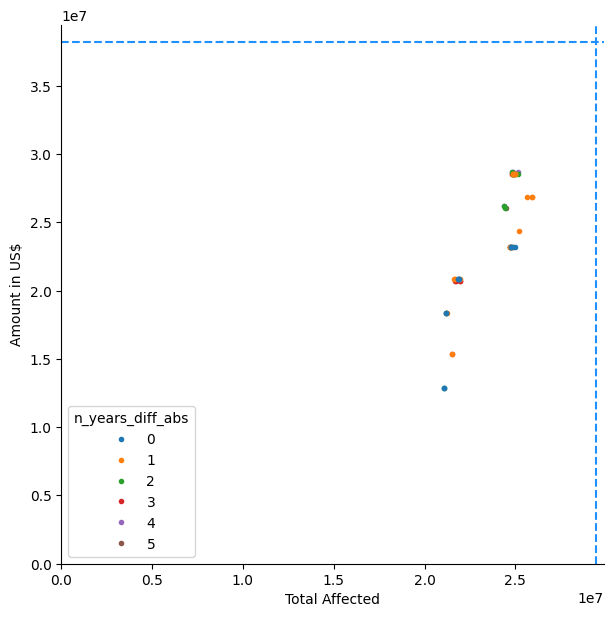

In [24]:
fig, ax = plot_thresh_scatter(
    df=df_metrics_reasonable,
    zero_intercept=True,
    # color="n_years_diff",
    # zorder_rev=False,
)

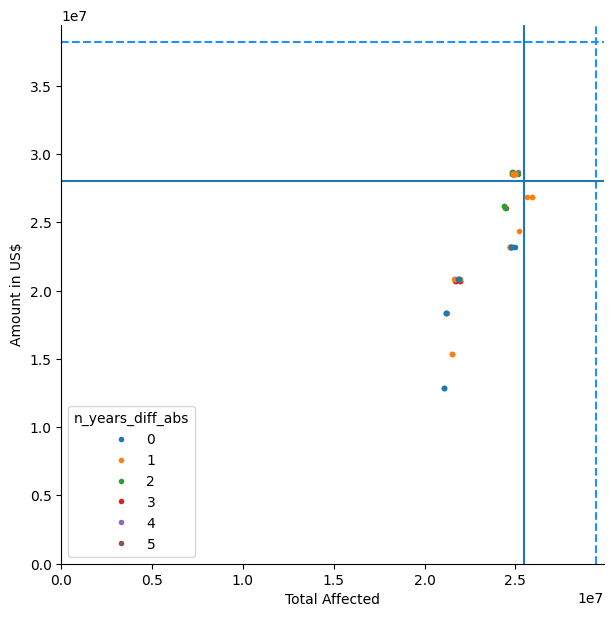

In [25]:
fig, ax = plot_thresh_scatter(
    df=df_metrics_reasonable,
    zero_intercept=True,
    # color="n_years_diff",
    # zorder_rev=False,
)
ax.axhline(2.8e7)
ax.axvline(2.55e7)

In [26]:
df_metrics_reasonable_bestcerf = df_metrics_reasonable[
    df_metrics_reasonable["Amount in US$"] >= 2.8e7
]

In [27]:
df_metrics_reasonable_bestcerf[
    df_metrics_reasonable_bestcerf["n_years_diff"] == 1
]

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total,fcast_cat,obsv_cat,cat_diff,min_cat
40495,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,q50,7.418959,115.0,q50_obsv,2.440000,7,6,1,1,13,4,4,0,4
40206,24892721.0,41.0,11268506.0,28547455.0,5.0,120.0,q50,17.138527,115.0,q50_obsv,2.440000,7,6,1,1,13,4,4,0,4
42148,24892721.0,41.0,11268506.0,28547455.0,5.0,120.0,q80,38.042336,115.0,q80_obsv,12.709001,7,6,1,1,13,4,4,0,4
40872,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,q80,35.698547,115.0,q80_obsv,12.709001,7,6,1,1,13,4,4,0,4
13724,24892721.0,41.0,11268506.0,28547455.0,5.0,120.0,q80,38.042336,105.0,q80_obsv,96.217003,7,6,1,1,13,4,3,1,3
13136,24992721.0,45.0,12317493.0,28547455.0,5.0,120.0,q80,35.698547,105.0,q80_obsv,96.217003,7,6,1,1,13,4,3,1,3


#### Option 1b

Maximizing CERF, taking closest to balanced (`n_years_diff == 1`), and lowest obsv wind threshold.

(<Figure size 2800x1400 with 2 Axes>,
 array([<Axes: title={'center': 'Action (forecast)'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, 80th quantile over whole country (mm)'>,
        <Axes: title={'center': 'Observational'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, 80th quantile over whole country (mm)'>],
       dtype=object))

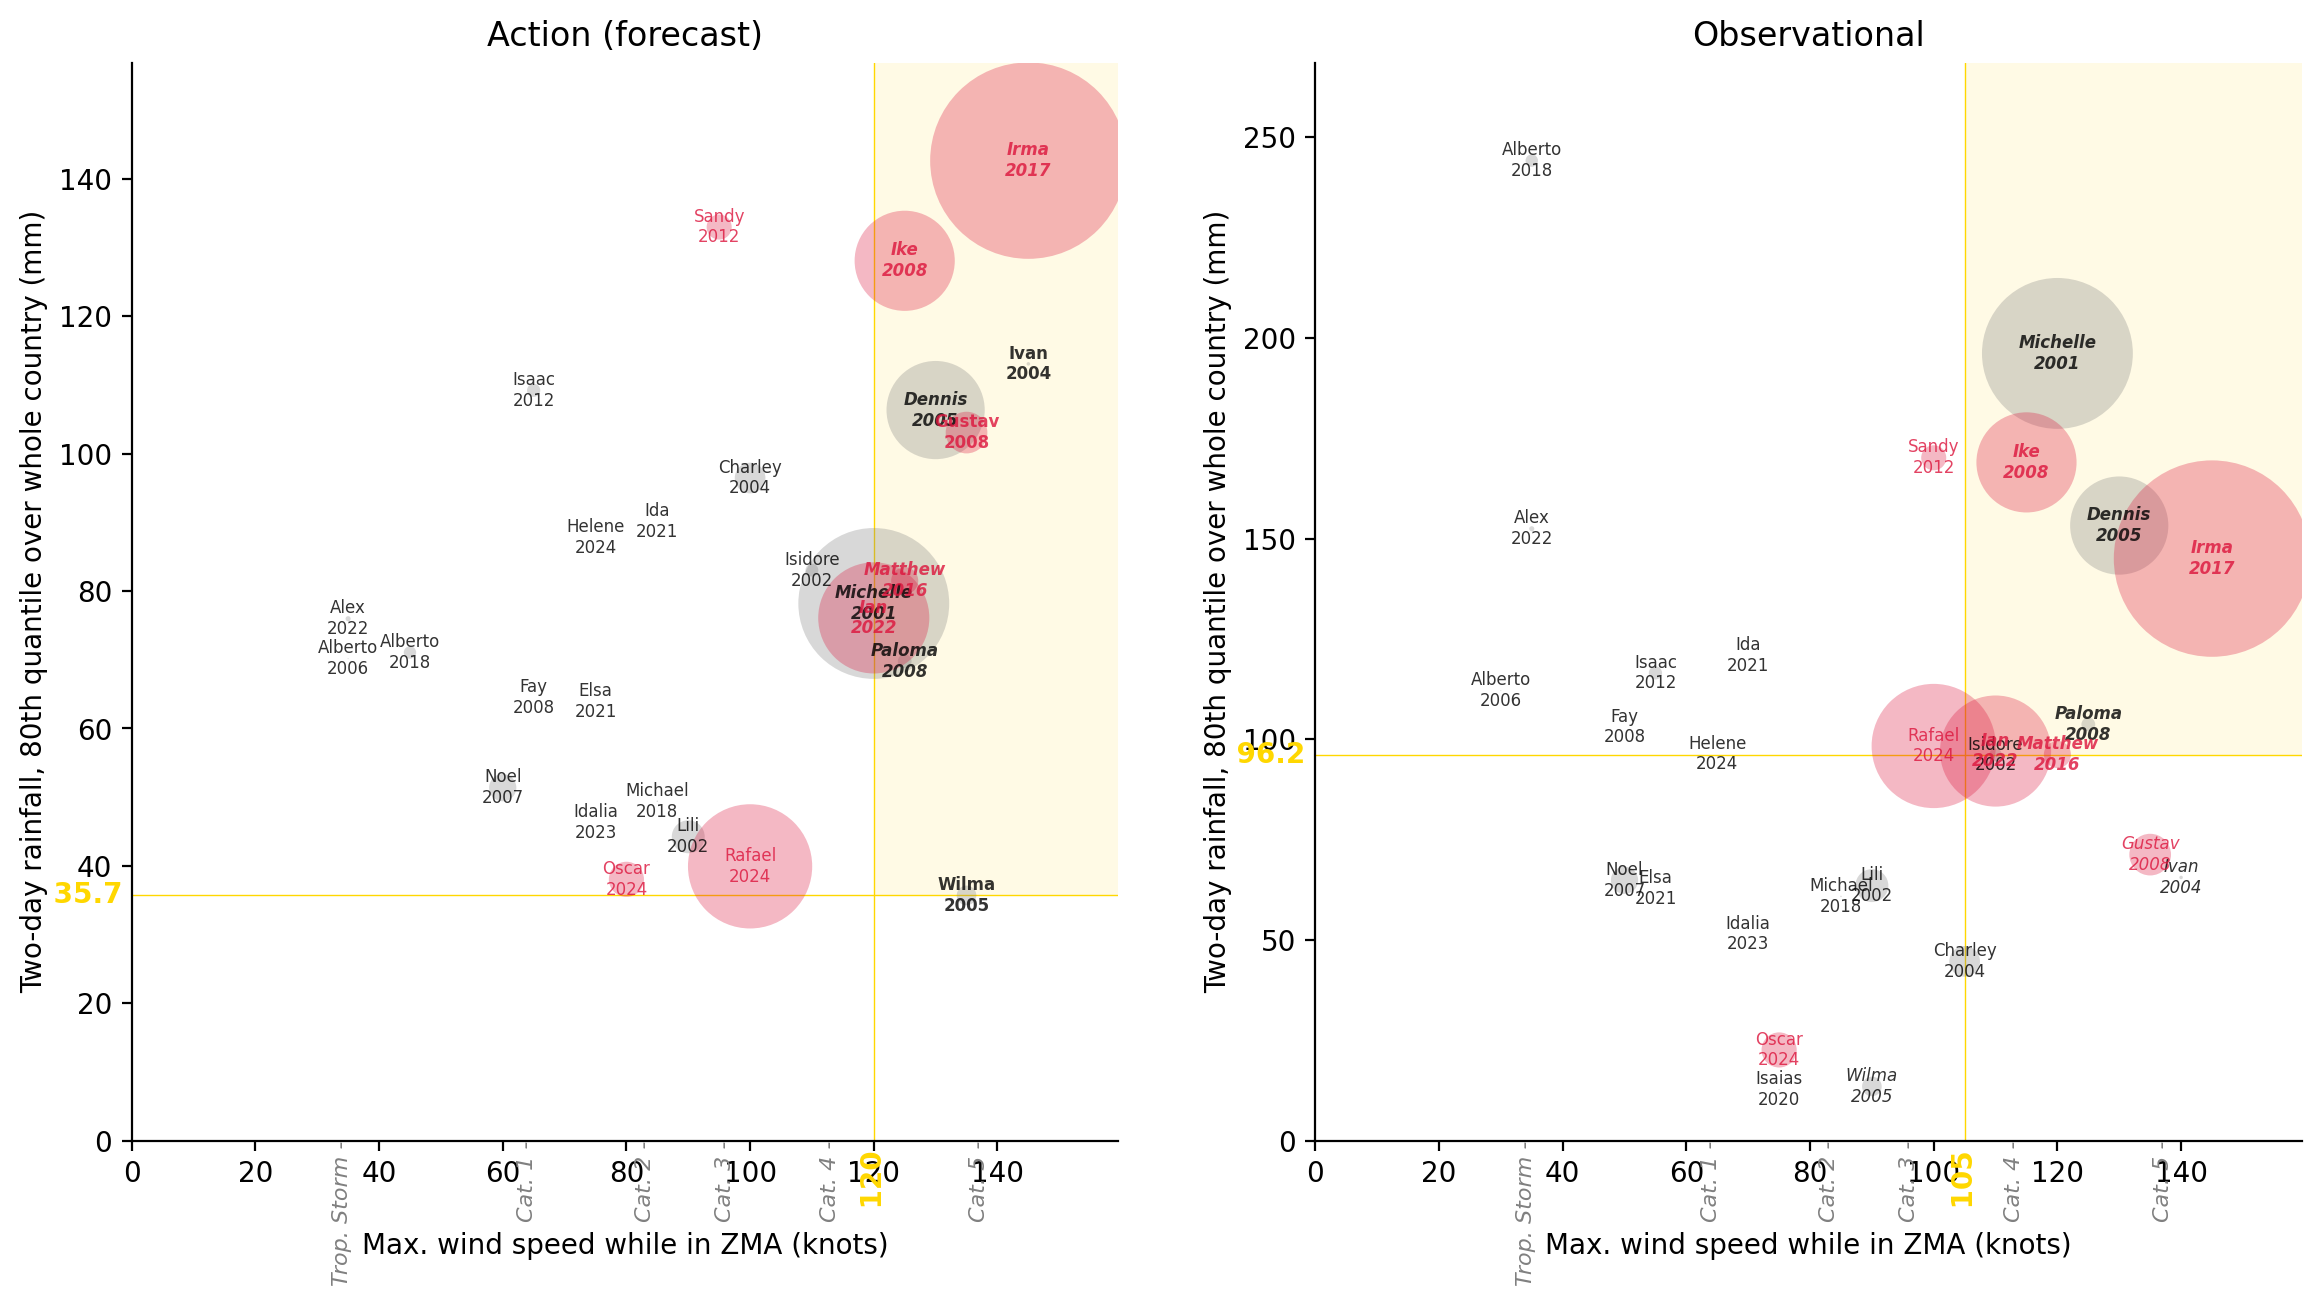

In [28]:
plot_selected_threshs(13136)

In [29]:
disp_selected_threshs(13136)

,Action,Obsv.,CERF,Total Affected
Storm,,,,
Irma 2017,Trig.,Trig.,Yes,"10,000,000"
Michelle 2001,Trig.,Trig.,pre-,"5,900,012"
Rafael 2024,No trig.,No trig.,Yes,"4,000,000"
Ian 2022,Trig.,Trig.,Yes,"3,200,000"
Ike 2008,Trig.,Trig.,Yes,"2,600,000"
Dennis 2005,Trig.,Trig.,pre-,"2,500,000"
Gustav 2008,Trig.,No trig.,Yes,"450,019"
Oscar 2024,No trig.,No trig.,Yes,"320,000"
Lili 2002,No trig.,No trig.,pre-,"281,470"


#### Option 4

Taking the maximum impact just ends up with option 4 again

In [30]:
df_metrics_reasonable_bestimpact = df_metrics_reasonable[
    df_metrics_reasonable["Total Affected"] >= 2.55e7
]

In [31]:
df_metrics_reasonable_bestimpact

,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,cerf,fcast_wind,fcast_rain_col,fcast_rain_thresh,obsv_wind,obsv_rain_col,obsv_rain_thresh,n_years_fcast,n_years_obsv,n_years_diff,n_years_diff_abs,n_years_total,fcast_cat,obsv_cat,cat_diff,min_cat
111447,25909331.0,53.0,9622569.0,26889626.0,5.0,90.0,q80,87.754250,75.0,q80_obsv,98.341003,5,6,-1,1,11,2,1,1,1
322018,25665326.0,49.0,8073174.0,26889626.0,5.0,75.0,q80,103.080360,75.0,q80_obsv,98.341003,5,6,-1,1,11,1,1,0,1
321972,25909331.0,53.0,9622569.0,26889626.0,5.0,75.0,q80,96.462585,75.0,q80_obsv,98.341003,5,6,-1,1,11,1,1,0,1


(<Figure size 2800x1400 with 2 Axes>,
 array([<Axes: title={'center': 'Action (forecast)'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, 80th quantile over whole country (mm)'>,
        <Axes: title={'center': 'Observational'}, xlabel='\nMax. wind speed while in ZMA (knots)', ylabel='Two-day rainfall, 80th quantile over whole country (mm)'>],
       dtype=object))

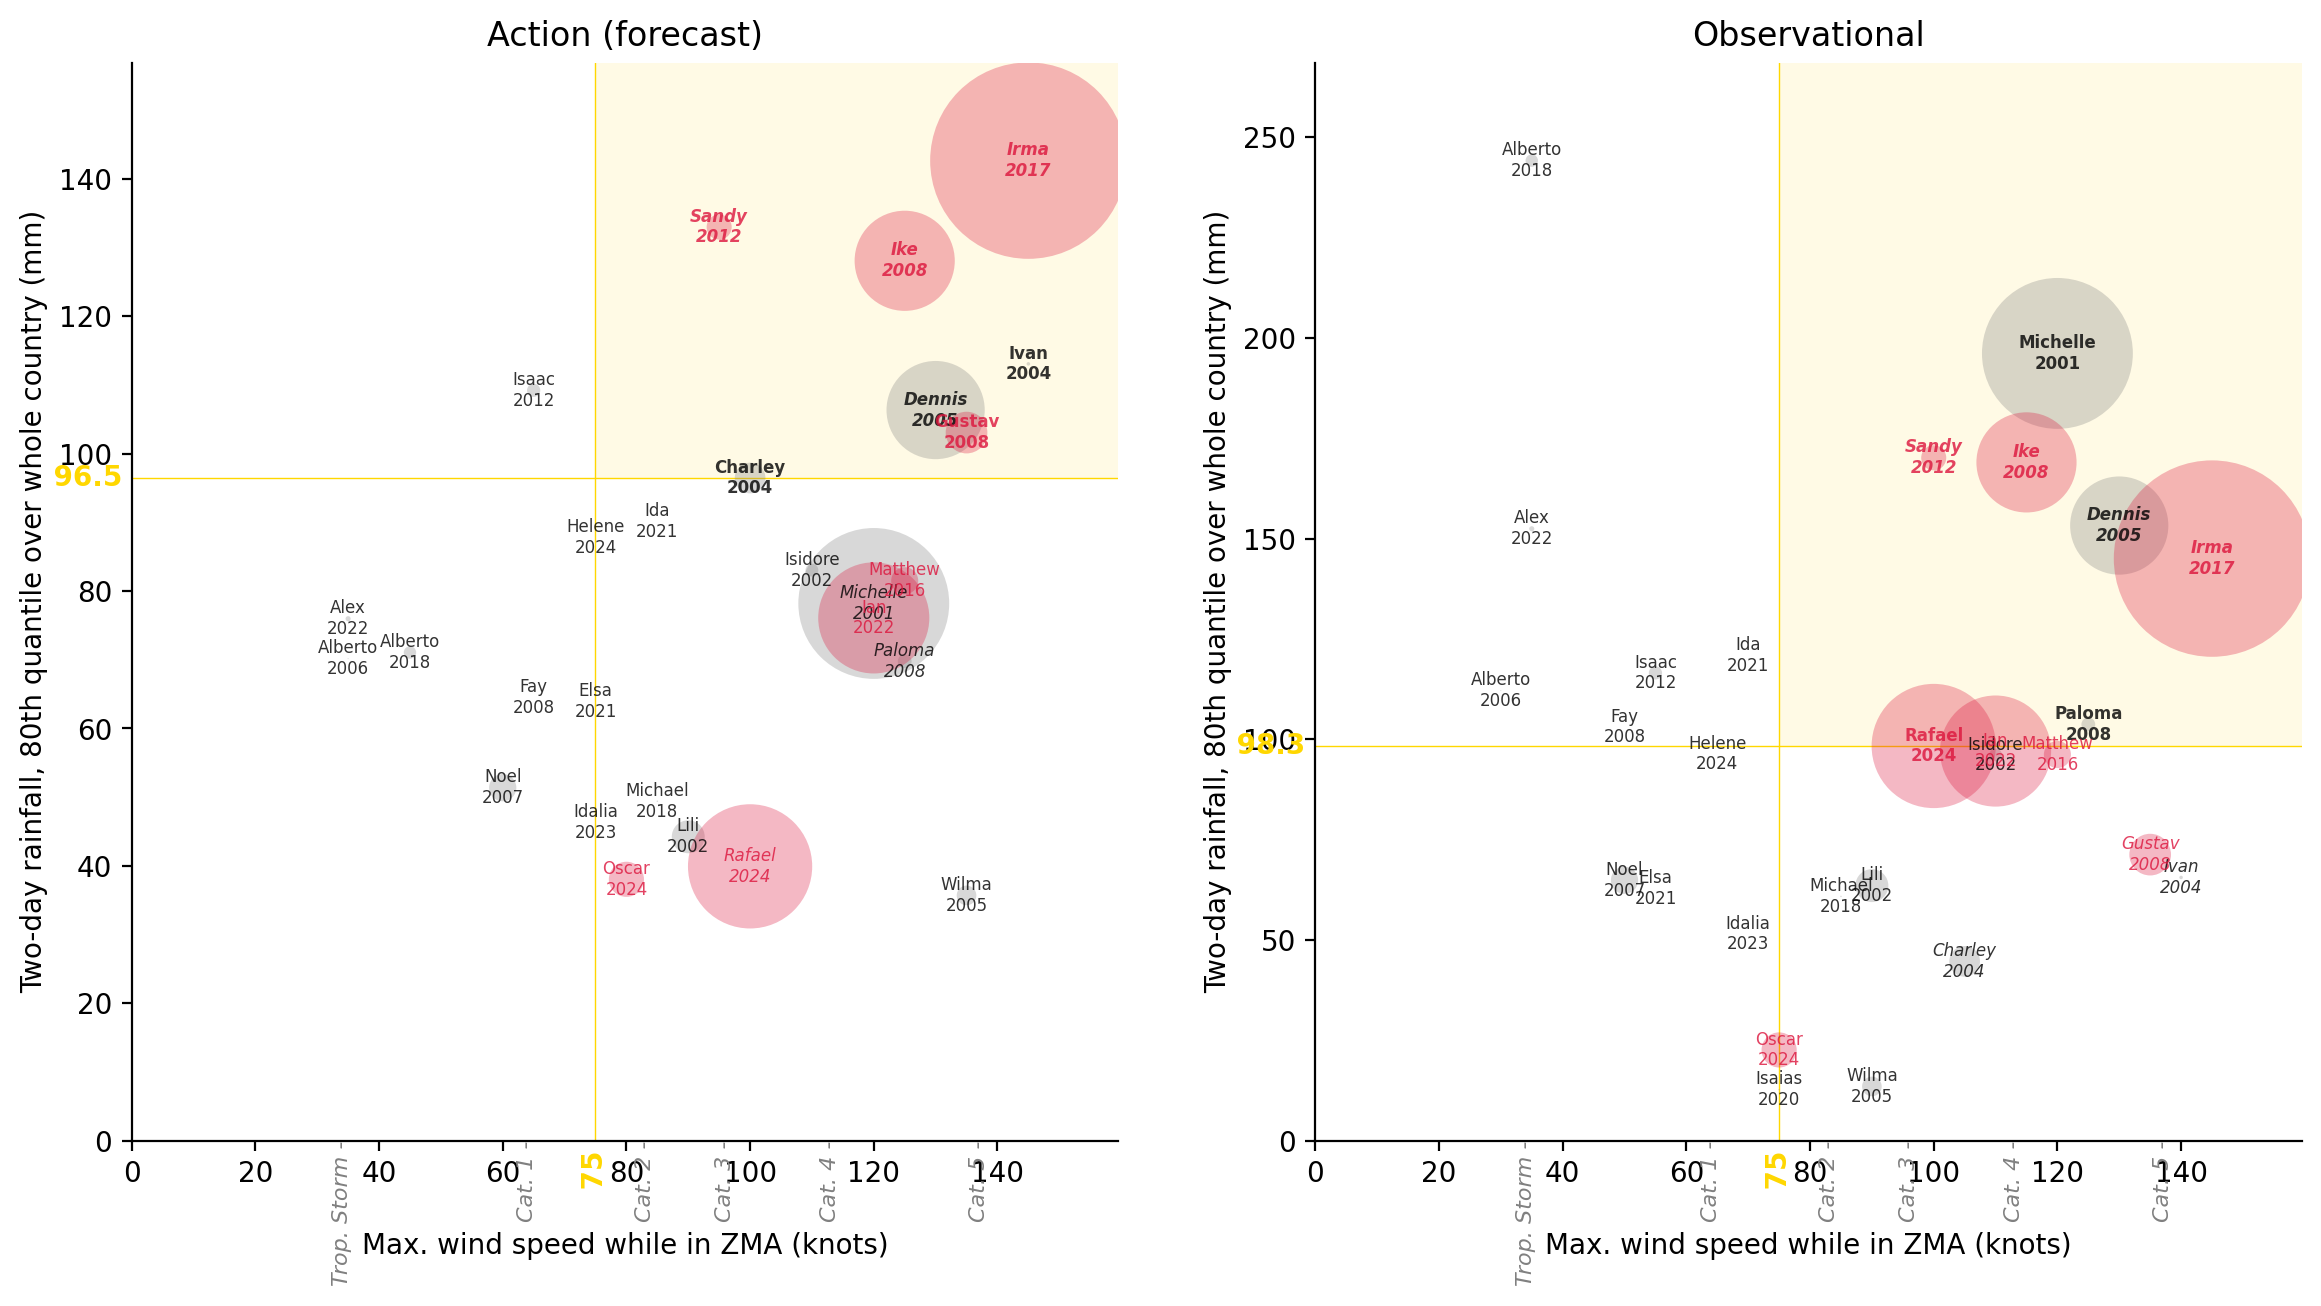

In [32]:
plot_selected_threshs(321972)

In [33]:
disp_selected_threshs(321972)

,Action,Obsv.,CERF,Total Affected
Storm,,,,
Irma 2017,Trig.,Trig.,Yes,"10,000,000"
Michelle 2001,No trig.,Trig.,pre-,"5,900,012"
Rafael 2024,No trig.,Trig.,Yes,"4,000,000"
Ian 2022,No trig.,No trig.,Yes,"3,200,000"
Ike 2008,Trig.,Trig.,Yes,"2,600,000"
Dennis 2005,Trig.,Trig.,pre-,"2,500,000"
Gustav 2008,Trig.,No trig.,Yes,"450,019"
Oscar 2024,No trig.,No trig.,Yes,"320,000"
Lili 2002,No trig.,No trig.,pre-,"281,470"


## Melissa

Plotting Melissa on the Option 4 plot to show how extreme the rainfall forecast is.

In [37]:
CHD_GREEN = "#1bb580"

Text(0.5, 1.0, 'Rainfall vs. wind speed forecast')

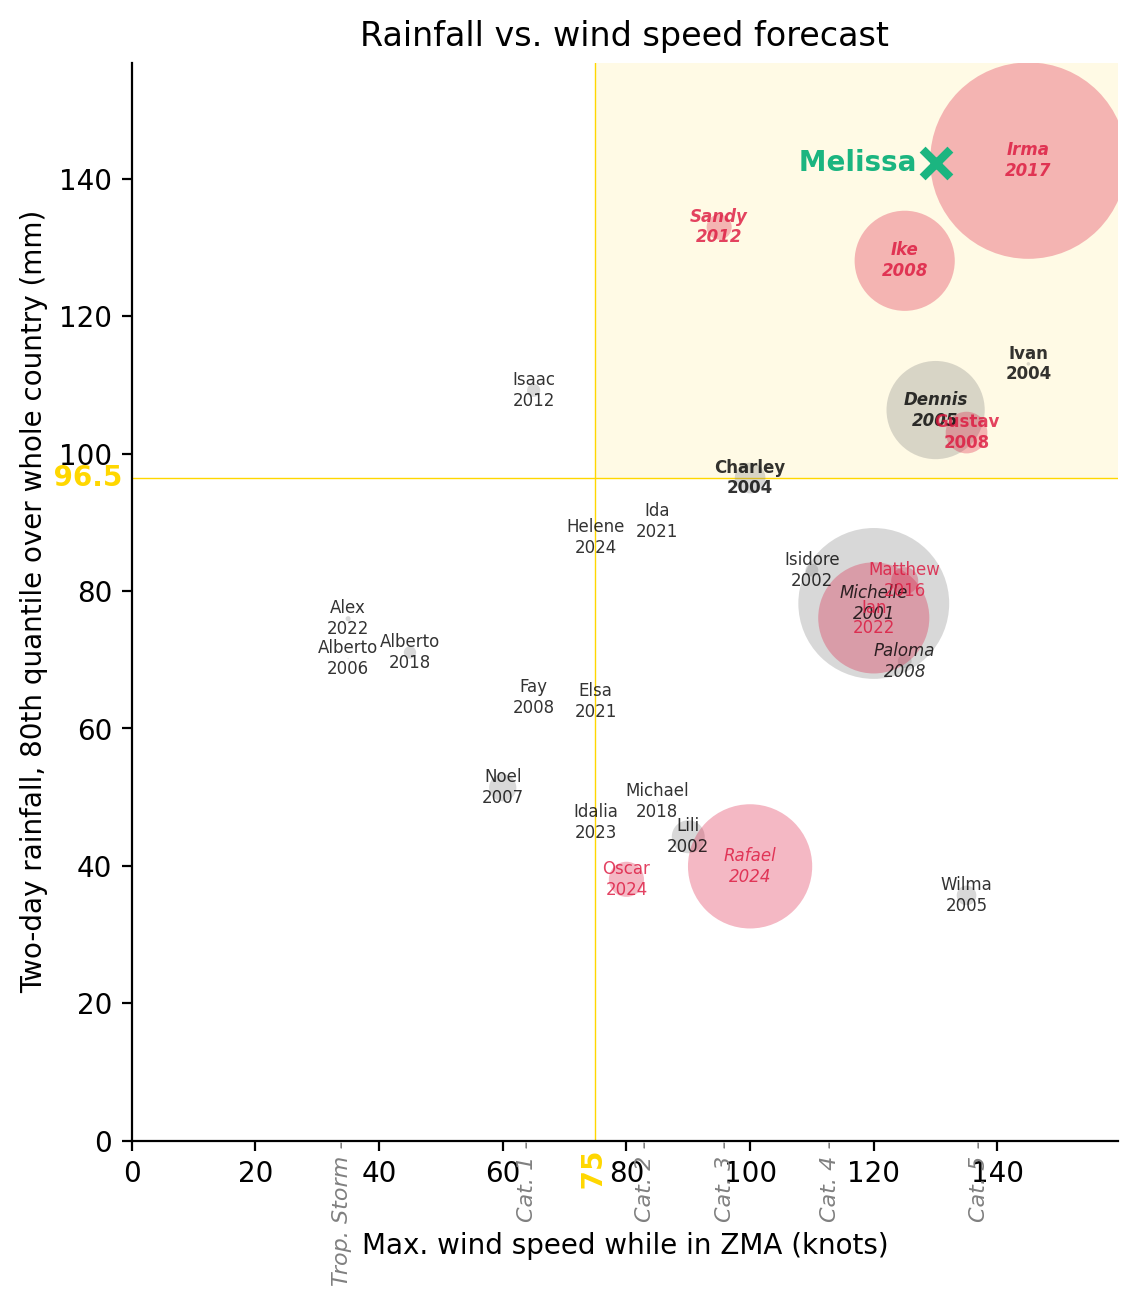

In [56]:
current_rain = 142.38818
current_wind = 130
fig, axs = plot_selected_threshs(321972)
axs[0].scatter(
    [current_wind],
    [current_rain],
    marker="x",
    color=CHD_GREEN,
    linewidths=3,
    s=100,
)
axs[0].annotate(
    "   Melissa  ",
    (current_wind, current_rain),
    va="center",
    ha="right",
    color=CHD_GREEN,
    fontweight="bold",
)
axs[1].remove()
axs[0].set_title("Rainfall vs. wind speed forecast")